# Explore the Intracellular and Extracellular CAZymes Within the CAZome of _Pectobacterium_ and _Dickeya_ Genomes

This notebook explores intracellular and extracellular CAZymes and CAZy families in 200 complete Refseq _Pectobacterium_ and _Dickeya_ CAZomes.

## Table of Contents

0. [Imports](#imports)
    * Load packages
    * Load in data
1. [CAZome size](#cazome-size)
    * Compare the number of CAZymes
    * Compare the proportion of the proteome represented by the CAZomes
2. [CAZy classes](#cazy-classes)
    * The number of CAZymes per CAZy class
    * Mean (+/- SD) number of CAZymes per CAZy class per genus
3. [CAZy families](#cazy-families)
    * Calculate CAZy family frequencies per genome
    * Plot a clustermap of CAZy family frequencies
4. [Core CAZome](#core-cazome)
    * Identify families that are present in all genomes
    * Calculate the frequency of families in the core CAZome
    * [_Pectobacterium_](#pecto-core-cazome) core CAZome
    * [_Dickeya_](#dic-core-cazome)
5. [Always co-occurring families](#co-occurring)
    * Identify CAZy families that are always present in the genome together
    * Explore across all _Pectobacterium_ and _Dickeya_ genomes, and per genus
    * Build an upset plot of co-occurring CAZy families
    * Compile a matrix with the indcidence data for each group of co-occurring CAZy families
6. [Principal Component Analysis (PCA)](#pca)
    * Explore the association between the host range, global distribution and composition of the CAZome
    * Explore across all _Pectobacterium_ and _Dickeya_ genomes, and per genus

<a id="imports"></a>
## 0. Imports

### Packages

In [1]:
!pip3 install adjusttext
!pip3 install -e /home/emmah/eastbio_storage/cazomevolve_dev/

Obtaining file:///home/emmah/eastbio_storage/cazomevolve_dev
  Preparing metadata (setup.py) ... done


  Attempting uninstall: cazomevolve
    Found existing installation: cazomevolve 0.0.4
    Uninstalling cazomevolve-0.0.4:
      Successfully uninstalled cazomevolve-0.0.4
  Running setup.py develop for cazomevolve


In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re

from copy import copy
from matplotlib.patches import Patch
from pathlib import Path
import upsetplot
import adjustText
import upsetplot

from Bio import SeqIO
from saintBioutils.utilities.file_io.get_paths import get_file_paths
from saintBioutils.utilities.file_io import make_output_directory
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

%matplotlib inline

In [3]:
# loading and parsing data
from cazomevolve.cazome.explore.parse_data import (
    load_fgp_data,
    load_tax_data,
    add_tax_data_from_tax_df,
    add_tax_column_from_row_index,
)

# functions for exploring the sizes of CAZomes
from cazomevolve.cazome.explore.cazome_sizes import (
    calc_proteome_representation,
    count_items_in_cazome,
    get_proteome_sizes,
)

# explore the frequency of CAZymes per CAZy class
from cazomevolve.cazome.explore.cazy_classes import calculate_class_sizes

# explore the frequencies of CAZy families and identify the co-cazome
from cazomevolve.cazome.explore.cazy_families import (
    build_fam_freq_df,
    build_row_colours,
    build_family_clustermap,
    identify_core_cazome,
    plot_fam_boxplot,
    build_fam_mean_freq_df,
    get_group_specific_fams,
    build_family_clustermap_multi_legend,
)

# functions to identify and explore CAZy families that are always present together
from cazomevolve.cazome.explore.cooccurring_families import (
    identify_cooccurring_fams_corrM,
    calc_cooccuring_fam_freqs,
    identify_cooccurring_fam_pairs,
    add_to_upsetplot_membership,
    build_upsetplot,
    get_upsetplot_grps,
    add_upsetplot_grp_freqs,
    build_upsetplot_matrix,
)

# functions to perform PCA
from cazomevolve.cazome.explore.pca import (
    perform_pca,
    plot_explained_variance,
    plot_scree,
    plot_pca,
    plot_loadings,
    plot_ie_loadings,
)
# functions to explore IE CAZymes
from cazomevolve.cazome.explore.ie_cazymes import (
    get_ie_fams
)

In [4]:
output_dir = Path("../results/pecto_dic/ie_cazymes")
make_output_directory(output_dir, force=True, nodelete=True)

Output directory ../results/pecto_dic/ie_cazymes exists, nodelete is True. Adding output to output directory.


### Data 

**CAZy family annotations: The GFP file**

Load tab delimited list of cazy families, genomes and protein accessions, by providing the path to the 'gfp file' to `load_gfp_data()`.

Each unique protein-family pair is represented on a separate line. Owing to a protein potentially containing multiple CAZyme domains and thus can be annotated with multiple CAZy families, a single protein can be present on multiple rows in the `gfp_df`.

In [5]:
fgp_file = "../data/pecto_dic/cazomes/pd_IE_fam_genomes_proteins"

fgp_df = pd.read_table(fgp_file, index_col="Unnamed: 0")
fgp_df.head(3)

Fam           Genome         Protein
0   e_GH8  GCF_000365365.1  WP_024104087.1
1  i_GT51  GCF_000365365.1  WP_024104265.1
2  i_GH32  GCF_000365365.1  WP_024104299.1

In [6]:
len(set(fgp_df['Protein']))

10885

**Taxonomy data:**

Load in CSV of tax data from generated by `cazevolve_add_taxs`, by providing a path to the file to `load_tax_data()`, and specify which tax ranks (kingdom, phylum, etc.) are included in the CSV file.

In [7]:
help(load_tax_data)

Help on function load_tax_data in module cazomevolve.cazome.explore.parse_data:

load_tax_data(tax_csv_path, kingdom=False, phylum=False, tax_class=False, tax_order=False, tax_family=False, genus=False, species=False)
    Load tax data compiled by cazomevolve into a pandas df
    
    :param tax_csv_path: str/Path to csv file of genome, tax_rank, tax_rank
        e.g. 'Genome', 'Genus', 'Species'
    The remaining params are bool checks for lineage ranks included in the tax data file
    
    Return df of genome, tax_rank, tax_rank,  e.g. 'Genome', 'Genus', 'Species'



In [8]:
tax_csv_path = "../data/pecto_dic/cazomes/fg_genome_taxs.csv"
tax_df = load_tax_data(tax_csv_path, genus=True, species=True)
tax_df.head(3)

Genome           Genus       Species
0  GCF_015277635.1  Pectobacterium    aroidearum
1  GCF_016944315.1  Pectobacterium   brasiliense
2  GCF_007210685.1         Dickeya  chrysanthemi

**Compile all data into a single dataframe:**

Build dataframe of:
* CAZy family annotations
* Genomic accession
* Taxonomic infomration - splitting each taxonomy rank (i.e. ranks) into a separate column. E.g.:
    * Genus
    * Species

In [9]:
fgp_df = add_tax_data_from_tax_df(
    fgp_df,
    tax_df,
    genus=True,
    species=True,
)
fgp_df.head(3)

Fam           Genome         Protein    Genus      Species
0   e_GH8  GCF_000365365.1  WP_024104087.1  Dickeya  dianthicola
1  i_GT51  GCF_000365365.1  WP_024104265.1  Dickeya  dianthicola
2  i_GH32  GCF_000365365.1  WP_024104299.1  Dickeya  dianthicola

In [10]:
fgp_df = fgp_df[fgp_df['Genus'] != 'Hafnia']
len(set(fgp_df['Protein']))

10810

<a id="cazome-size"> </a>
## 1. CAZome size

The number of CAZymee, total proteins, and CAZy families are calculated in `notebookes/explore_pecto_dic_cazomes.ipynb` notebook. This notebook explores the intracellular and extracellular CAZy families.

Calculate the number of intracellular families, extracellular families and families containing both intracellular and extracellular CAZymes.

In [11]:
help(get_ie_fams)

Help on function get_ie_fams in module cazomevolve.cazome.explore.ie_cazymes:

get_ie_fams(fgp_df)
    Identify families with intracellular, extracellular or both intra- and extra-cellular CAZymes
    
    :param fgp_df: df containing fams, taxs and genomes
    
    Return (return fam annotations exclude i_ and e_ prefix)
    * intra_fams: set of all fams with intracellular CAZymes
    * extra_fams: set of all fams with extracellular CAZYmes
    * intra_only_fams: set of fams with only I CAZymes
    * extra_only_fams: set of fams with only E CAZymes
    * both_intra_extra_fams: set of fams with both I and E CAZymes
    * all_fams: set of all fams



In [12]:
intra_fams, extra_fams, intra_only_fams, extra_only_fams, both_intra_extra_fams, all_fams = get_ie_fams(fgp_df)

Identifying IE fams: 100%|██████████| 28292/28292 [00:03<00:00, 7156.13it/s]


Num of fams with intracellular CAZymes: 78
Num of fams with extracellular CAZymes: 35


identifying IE fams: 100%|██████████| 87/87 [00:00<00:00, 271708.45it/s]

Total fams: 87
Num of fams with intracellular ONLY CAZymes: 52
Num of fams with extracellular ONLY CAZymes: 9
Num of fams with BOTH intracellular and extracellular CAZymes: 26


In [13]:
print("Extracellular only fams:")
for fam in extra_only_fams:
    print(f"- {fam}")

Extracellular only fams:
- PL10
- CBM3
- CBM32
- CE2
- CBM13
- CBM4
- AA10
- CBM63
- CBM5


In [14]:
print("Both intra and extra celluar fams:")
for fam in both_intra_extra_fams:
    print(f"- {fam}")

Both intra and extra celluar fams:
- CE4
- PL9
- PL4
- GH153
- GH24
- GH53
- GH18
- GT83
- PL3
- GH43
- CE12
- CE1
- GH23
- PL1
- CE8
- GH12
- GH3
- GH28
- GH102
- GH8
- GH13
- GH103
- PL2
- GH26
- GH30
- GH5


In [15]:
print("Intracellular only fams:")
for fam in intra_only_fams:
    print(f"- {fam}")

Intracellular only fams:
- CBM48
- CE11
- GT26
- GT4
- GH33
- GT14
- GT5
- GH94
- GT84
- GH19
- GT30
- GH42
- GH78
- CE9
- GH108
- GT19
- GT51
- GH1
- GH31
- GT2
- PL22
- GT56
- GH68
- GT52
- GH38
- GT11
- PL26
- GH91
- GT32
- GT73
- GH73
- GT41
- GH65
- GT25
- GH105
- PL11
- GT20
- GT97
- GH88
- GT28
- GT1
- GH2
- GH4
- GH32
- GH36
- GT9
- GT81
- AA3
- GT35
- GT8
- GH104
- GH77


Now look per genus

### Pectobacterium

In [16]:
fgp_df_pecto = fgp_df[fgp_df['Genus'] == 'Pectobacterium']
(
    p_intra_fams,
    p_extra_fams,
    p_intra_only_fams,
    p_extra_only_fams,
    p_both_intra_extra_fams, 
    p_all_fams,
) = get_ie_fams(fgp_df_pecto)

Identifying IE fams: 100%|██████████| 19045/19045 [00:02<00:00, 6723.91it/s]


Num of fams with intracellular CAZymes: 72
Num of fams with extracellular CAZymes: 29


identifying IE fams: 100%|██████████| 80/80 [00:00<00:00, 417343.68it/s]

Total fams: 80
Num of fams with intracellular ONLY CAZymes: 51
Num of fams with extracellular ONLY CAZymes: 8
Num of fams with BOTH intracellular and extracellular CAZymes: 21


### Dickeya

In [17]:
fgp_df_dic = fgp_df[fgp_df['Genus'] == 'Dickeya']
(
    d_intra_fams,
    d_extra_fams,
    d_intra_only_fams,
    d_extra_only_fams,
    d_both_intra_extra_fams, 
    d_all_fams,
) = get_ie_fams(fgp_df_dic)

Identifying IE fams: 100%|██████████| 9247/9247 [00:01<00:00, 5023.31it/s]


Num of fams with intracellular CAZymes: 60
Num of fams with extracellular CAZymes: 23


identifying IE fams: 100%|██████████| 67/67 [00:00<00:00, 460685.85it/s]

Total fams: 67
Num of fams with intracellular ONLY CAZymes: 44
Num of fams with extracellular ONLY CAZymes: 7
Num of fams with BOTH intracellular and extracellular CAZymes: 16


### Summarise

Build a table to summarise these results consisting of three columns: Pectobacterium, Both, Dickeya; and lists three rows: Intracellular, Both, Extracellular

In [18]:
# p = pectobacterium; b = both; d = dickeya; i = intracellular; e = extracellular
pi = set()
pb = set()
pe = set()
bi = set()
bb = set()
be = set()
di = set()
db = set()
de = set()
for fam in tqdm(all_fams, desc='Summarising data'):
    # check if a P, B or D fam
    if (fam in p_all_fams) and (fam not in d_all_fams):
        # P FAM
        
        # check if I, B or E fam
        if fam in p_intra_only_fams:
            # PI FAM
            pi.add(fam)
            continue
            
        if fam in p_both_intra_extra_fams:
            # PB FAM
            pb.add(fam)
            continue
            
        else:
            # PE FAM
            pe.add(fam)
            continue
    
    elif (fam not in p_all_fams) and (fam in d_all_fams):
        # D FAM
        
        # check if I, B or E fam
        if fam in d_intra_only_fams:
            # DI FAM
            di.add(fam)
            continue
            
        if fam in d_both_intra_extra_fams:
            # DB FAM
            db.add(fam)
            continue
            
        else:
            # DE FAM
            de.add(fam)
            continue
    
    else:
        # B FAM (both)
        
        # check if I, B or E fam
        # check if classifications match
        if (fam in p_intra_only_fams) and (fam in d_intra_only_fams):
            # BI FAM
            bi.add(fam)
            continue
            
        elif (fam in p_both_intra_extra_fams) and (fam in d_both_intra_extra_fams):
            # BB FAM
            bb.add(fam)
            continue
            
        elif (fam in p_extra_only_fams) and (fam in d_extra_only_fams):
            # BE FAM
            be.add(fam)
            continue
            
        # could be present in both, but I in one and E in the other
        # not placing in the middle column
        # fam will be added to both the P and D columns so check separately
        
        # PECTOBACTERIUM
        if fam in p_intra_only_fams:
            pi.add(fam)
            
        elif fam in p_extra_only_fams:
            pe.add(fam)
            
        elif fam in p_both_intra_extra_fams:
            pb.add(fam)
        
        # DICKEYA
        if fam in d_intra_only_fams:
            di.add(fam)
            
        elif fam in d_extra_only_fams:
            de.add(fam)
            
        elif fam in d_both_intra_extra_fams:
            db.add(fam)

Summarising data:   0%|          | 0/87 [00:00<?, ?it/s]

Split up each group (`pi, pb, pe, bi...`) into each CAZy class so that families are listed in logical order.

Technical each row ('Intracellular', 'Both', 'Extracellular') will be split up into 6 (sub)rows (one per CAZy class).

In [19]:
def order_fams(grp, cazy_classes = ['GH', 'GT', 'PL', 'CE', 'AA', 'CBM']):
    """Split up the fams into their CAZy classes
    
    :param grp: set of fams
    :param cazy_class: list of CAZy class, default: ['GH', 'GT', 'PL', 'CE', 'AA', 'CBM']
    
    Return list of nested lists, one nested list per CAZy class
    """
    new_grp_data = {}
    for c_class in cazy_classes:
        new_grp_data[c_class] = []
        
    for fam in grp:
        for c_class in cazy_classes:
            if fam.startswith(c_class):
                new_grp_data[c_class].append(fam)
                continue
    
    for c_class in new_grp_data:
        new_grp_data[c_class].sort()
        
    new_grp = [",".join(new_grp_data[c_class]) for c_class in new_grp_data]
    
    return new_grp

In [20]:
pi = order_fams(pi)
pb = order_fams(pb)
pe = order_fams(pe)
bi = order_fams(bi)
bb = order_fams(bb)
be = order_fams(be)
di = order_fams(di)
db = order_fams(db)
de = order_fams(de)

In [21]:
df_data = []
df_row_data = {'i': [pi, bi, di], 'b': [pb, bb, db], 'e': [pe, be, de]}
for row in df_row_data:
    
    for i in range(len(df_row_data[row][0])):
        # one i per cazy_class
        class_row = []
        class_row.append(df_row_data[row][0][i])
        class_row.append(df_row_data[row][1][i])
        class_row.append(df_row_data[row][2][i])
        df_data.append(class_row)

    # p = df_row_data[row][0]
    # b = df_row_data[row][1]
    # d = df_row_data[row][2]
    
ie_sum_df = pd.DataFrame(df_data, columns=['Pectobacterium', 'Both', 'Dickeya'])
row_names = []
for row in df_row_data:
    for i in range(len(df_row_data[row][0])):
        # one i per cazy_class
        if i == 0:
            row_names.append(row)
        else:
            row_names.append('')
ie_sum_df['grp'] = row_names
ie_sum_df = ie_sum_df.set_index('grp')

ie_sum_df.to_csv(output_dir/"ie_families.csv")
ie_sum_df

Pectobacterium   
grp                                            
i                       GH108,GH24,GH65,GH68  \
     GT11,GT14,GT20,GT25,GT32,GT52,GT73,GT83   
                                        PL11   
                                               
                                               
                                               
b             GH102,GH12,GH13,GH153,GH18,GH8   
                                               
                                         PL2   
                                     CE4,CE8   
                                               
                                               
e                                   GH30,GH5   
                                               
                                               
                                               
                                        AA10   
                       CBM13,CBM3,CBM32,CBM5   

                                                  Both         Dickeya  
grp                                                                     
i    GH1,GH104,GH105,GH19,GH2,GH31,GH32,GH33,GH36,G...   GH13,GH5,GH91  
     GT1,GT19,GT2,GT26,GT28,GT30,GT35,GT4,GT41,GT5,...            GT97  
                                             PL22,PL26             PL2  
                                              CE11,CE9                  
                                                                   AA3  
                                                 CBM48                  
b                        GH103,GH23,GH28,GH3,GH43,GH53  GH24,GH26,GH30  
                                                                  GT83  
                                       PL1,PL3,PL4,PL9                  
                                              CE1,CE12                  
                                                                        
                                                                        
e                                                            GH102,GH8  
                                                                        
                                                                  PL10  
                                                               CE2,CE8  
                                                                        
                                                 CBM63            CBM4

Find families that differ between the genera, e.g. find a family that is intracellular in one genus and extracellular in the other.

In [22]:
differings = []

for fam in tqdm(all_fams, desc="Find differing fams"):
    if (fam in p_intra_only_fams) and (fam in d_extra_only_fams):
        differings.append(f"[1] {fam} Intracellular in Pectobacterium Extracellular in Dickeya")
        
    elif (fam in p_intra_only_fams) and (fam in d_both_intra_extra_fams):
        differings.append(f"[2] {fam} Intracellular in Pectobacterium BOTH I+E in Dickeya")
        
    elif (fam in p_extra_only_fams) and (fam in d_both_intra_extra_fams):
        differings.append(f"[3] {fam} Extracellular in Pectobacterium BOTH I+E in Dickeya")
        
    elif (fam in p_extra_only_fams) and (fam in d_intra_only_fams):
        differings.append(f"[4] {fam} Extracellular in Pectobacterium and Intracellular in Dickeya")
        
    elif (fam in d_intra_only_fams) and (fam in p_extra_only_fams):
        differings.append(f"[5] {fam} Intracellular in Dickeya Extracellular in Pectobacterium")
        
    elif (fam in d_intra_only_fams) and (fam in p_both_intra_extra_fams):
        differings.append(f"[6] {fam} Intracellular in Dickeya BOTH I+E in Pectobacterium")
        
    elif (fam in d_extra_only_fams) and (fam in p_both_intra_extra_fams):
        differings.append(f"[7] {fam} Extracellular in Dickeya and BOTH I+E in Pectobacterium")
        
    elif (fam in d_extra_only_fams) and (fam in p_intra_only_fams):
        differings.append(f"[8] {fam} Extracellular in Dickeya and Intracellular in Pectobacterium")
        
differings.sort()
for differ in differings:
    print(differ)

Find differing fams:   0%|          | 0/87 [00:00<?, ?it/s]

[2] GH24 Intracellular in Pectobacterium BOTH I+E in Dickeya
[2] GT83 Intracellular in Pectobacterium BOTH I+E in Dickeya
[3] GH30 Extracellular in Pectobacterium BOTH I+E in Dickeya
[4] GH5 Extracellular in Pectobacterium and Intracellular in Dickeya
[6] GH13 Intracellular in Dickeya BOTH I+E in Pectobacterium
[6] PL2 Intracellular in Dickeya BOTH I+E in Pectobacterium
[7] CE8 Extracellular in Dickeya and BOTH I+E in Pectobacterium
[7] GH102 Extracellular in Dickeya and BOTH I+E in Pectobacterium
[7] GH8 Extracellular in Dickeya and BOTH I+E in Pectobacterium


<a id="cazy-classes"> </a>
## 2. CAZy classes

Any analysis here?

<a id="cazy-families"> </a>
## 3. CAZy families

### CAZy family frequency dataframe

Calculate the number of CAZymes per CAZy family presented in each genome, where the number of CAZymes is the number of unqiue protein accessions. This value may be greater than the number of CAZymes in the genome because a CAZyme may be annotated with multiple CAZy families.

In [23]:
fgp_df.columns=['Family','Genome','Protein','Genus','Species']

In [24]:
fam_freq_df = build_fam_freq_df(fgp_df, ['Genus', 'Species'])
make_output_directory(Path(output_dir/'cazy_families/'), force=True, nodelete=True)
fam_freq_df.to_csv(output_dir/"cazy_families/cazy_fam_freqs.csv")
fam_freq_df

The dataset contains 113 CAZy families


Counting fam frequencies: 100%|██████████| 280/280 [00:28<00:00,  9.67it/s]
Output directory ../results/pecto_dic/ie_cazymes/cazy_families exists, nodelete is True. Adding output to output directory.


Genome           Genus        Species  e_AA10  e_CBM13  e_CBM3   
0    GCF_000023605.1  Pectobacterium     aroidearum       0        1       1  \
1    GCF_016864975.1  Pectobacterium    brasiliense       0        0       1   
2    GCF_016949215.1  Pectobacterium  brasiliense A       0        1       0   
3    GCF_000975305.1         Dickeya    dianthicola       0        0       0   
4    GCF_000406325.1         Dickeya           zeae       0        0       0   
..               ...             ...            ...     ...      ...     ...   
275  GCF_018361225.1         Dickeya    dianthicola       0        0       0   
276  GCF_004137795.1  Pectobacterium  zantedeschiae       0        1       1   
277  GCF_000024645.1  Pectobacterium    parmentieri       0        1       1   
278  GCF_000808375.1  Pectobacterium    brasiliense       0        0       1   
279  GCF_012278555.1         Dickeya           zeae       0        0       0   

     e_CBM32  e_CBM4  e_CBM5  e_CBM63  ...  i_GT9  i_GT97  i_PL1  i_PL11   
0          1       0       0        1  ...      3       0      1       0  \
1          1       0       0        1  ...      3       0      1       0   
2          1       0       0        0  ...      3       0      0       0   
3          0       0       0        2  ...      4       0      2       0   
4          0       0       0        1  ...      4       0      2       0   
..       ...     ...     ...      ...  ...    ...     ...    ...     ...   
275        0       0       0        2  ...      4       0      2       0   
276        1       0       0        1  ...      4       0      3       0   
277        1       0       0        1  ...      3       0      1       0   
278        1       0       0        1  ...      4       0      1       0   
279        0       0       0        1  ...      4       0      2       0   

     i_PL2  i_PL22  i_PL26  i_PL3  i_PL4  i_PL9  
0        1       1       1      1      0      1  
1        1       1       1      1      0      0  
2        1       1       1      0      1      1  
3        1       1       1      1      1      0  
4        1       1       0      1      0      0  
..     ...     ...     ...    ...    ...    ...  
275      1       1       1      1      0      1  
276      1       1       1      1      0      0  
277      1       1       1      0      1      0  
278      1       1       0      1      0      0  
279      1       1       0      0      0      0  

[280 rows x 116 columns]

### Clustermaps

Build clustermap of CAZy family frequencies, with additional row colours marking the genus classification of each genome (i.e. each row).

**Prepare the dataframe of CAZy family frequencies:**

Index `fam_freq_df` so that each row name contains the genome, Genus and Species, so that the genomic accession, genus and species is included in the clustermap.

In [25]:
# index the taxonomy data and genome (ggs=genome_genus_species)
fam_freq_df_ggs = copy(fam_freq_df)  # so does not alter fam_freq_df
fam_freq_df_ggs = fam_freq_df_ggs.set_index(['Genome','Genus','Species'])
fam_freq_df_ggs.head(1)

e_AA10  e_CBM13  e_CBM3  e_CBM32   
Genome          Genus          Species                                        
GCF_000023605.1 Pectobacterium aroidearum       0        1       1        1  \

                                           e_CBM4  e_CBM5  e_CBM63  e_CE1   
Genome          Genus          Species                                      
GCF_000023605.1 Pectobacterium aroidearum       0       0        1      1  \

                                           e_CE12  e_CE2  ...  i_GT9  i_GT97   
Genome          Genus          Species                    ...                  
GCF_000023605.1 Pectobacterium aroidearum       1      0  ...      3       0  \

                                           i_PL1  i_PL11  i_PL2  i_PL22   
Genome          Genus          Species                                    
GCF_000023605.1 Pectobacterium aroidearum      1       0      1       1  \

                                           i_PL26  i_PL3  i_PL4  i_PL9  
Genome          Genus          Species                                  
GCF_000023605.1 Pectobacterium aroidearum       1      1      0      1  

[1 rows x 113 columns]

**Colour scheme:**

Define a colour scheme to colour code the rows by, in this case by the genus of the species.

To do this, add a column containing the data to be used to colour code each row, e.g. a genus. This extra column is removed by `build_row_colours()`. The dataframe that is parsed to `build_row_colours()` must be the dataframe that is used to generate a clustermap, otherwise Seaborn will not be able to map the row oclours correctly and no row colours will be produced.

In [26]:
# define a colour scheme to colour code rows by genus
fam_freq_df_ggs['Genus'] = list(fam_freq_df['Genus'])  # add column to use for colour scheme, is removed
fam_freq_genus_row_colours, fam_g_lut = build_row_colours(fam_freq_df_ggs, 'Genus', 'Set2')

**Build a clustermap of CAZy family frequencies:**

Use the function `build_family_clustermap()` from `cazomevolve` to build clustermaps of the CAZy family frequencies, with different combinations of additional row colours. For example, the row colours could list the genus and/or species classification of each genome.

/home/emmah/.conda/envs/pectobacteriaceae/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/emmah/.conda/envs/pectobacteriaceae/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


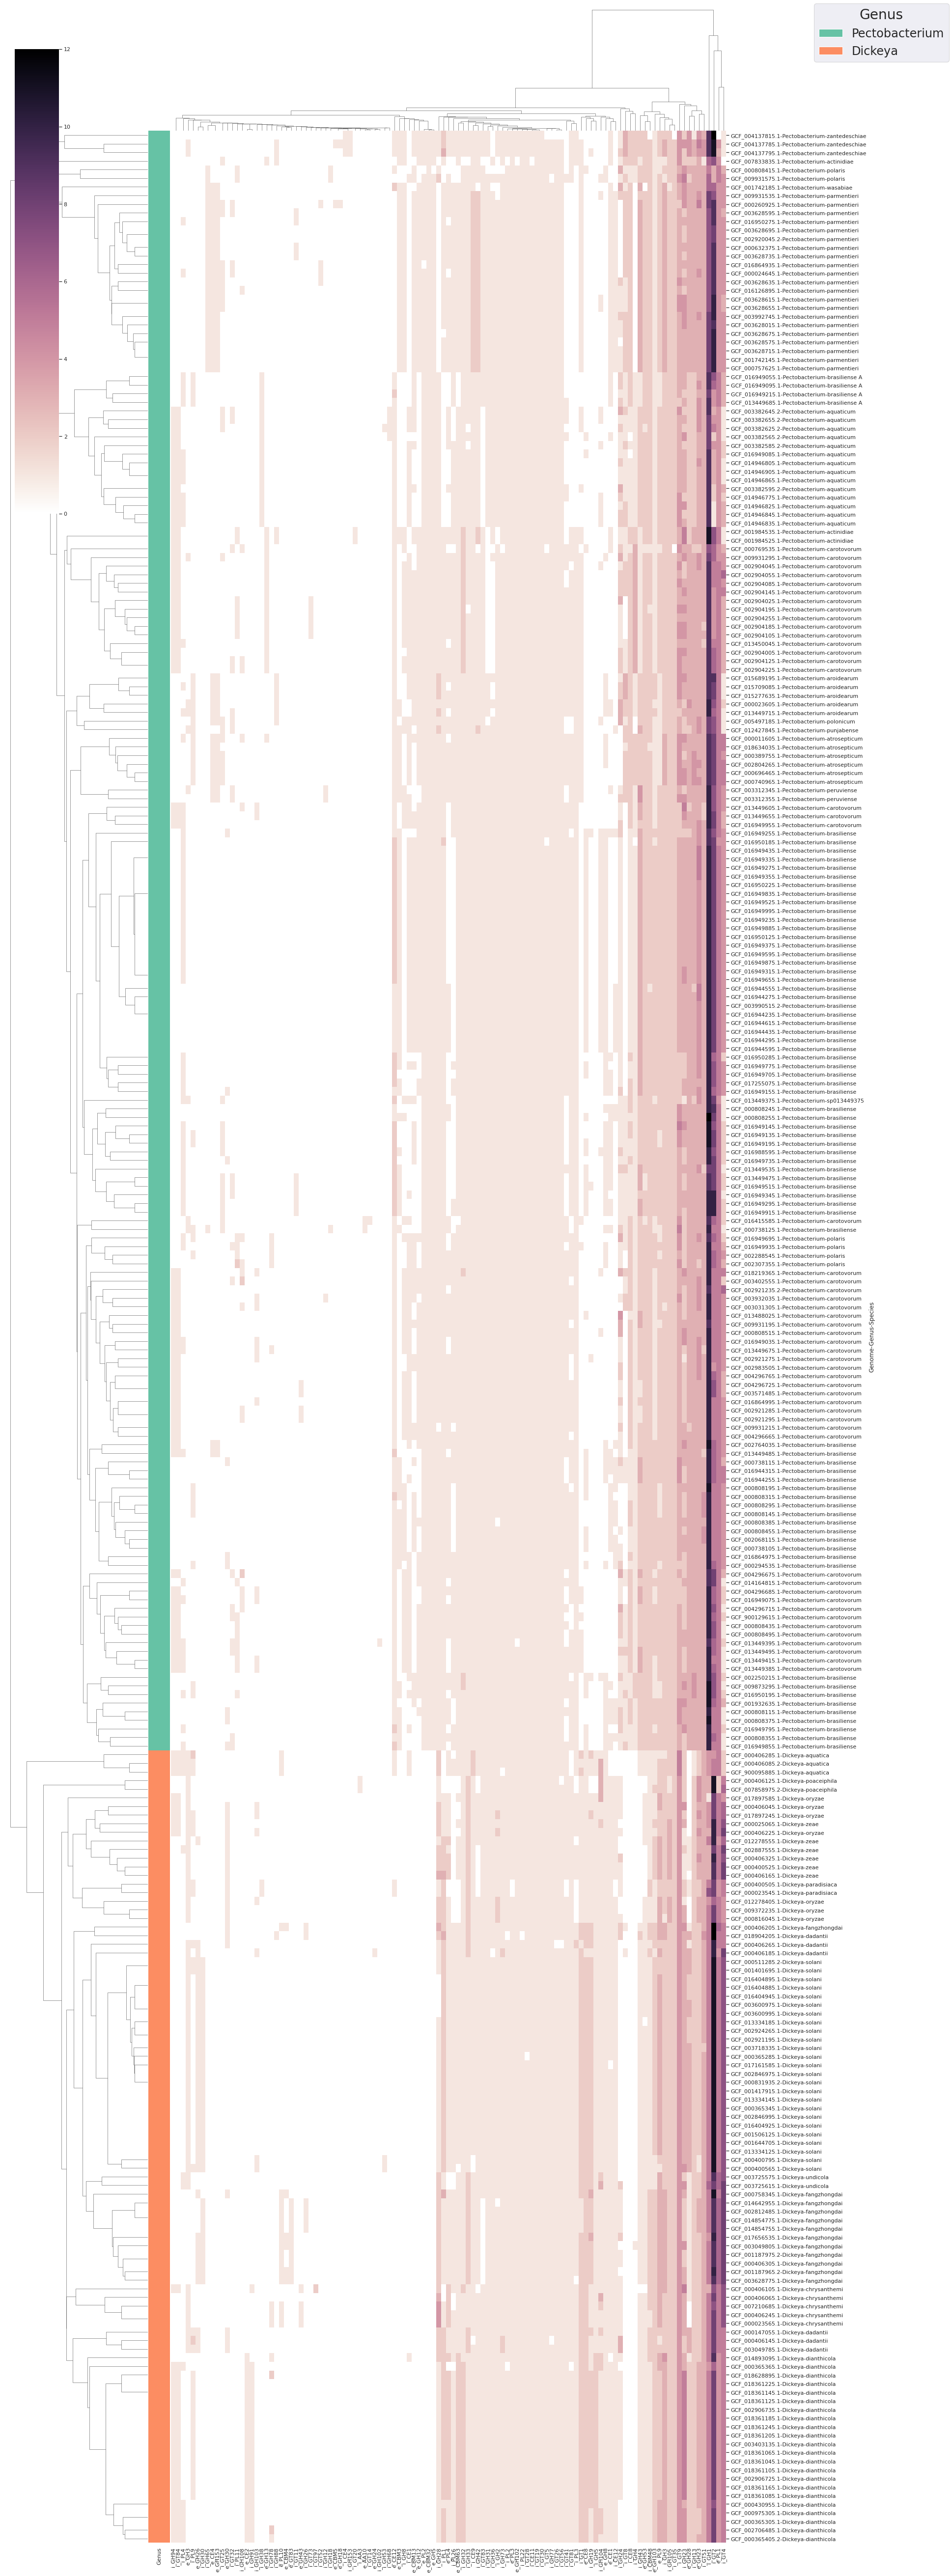

In [27]:
# make a figure that is full size, and all data is legible
build_family_clustermap(
    fam_freq_df_ggs,
    row_colours=fam_freq_genus_row_colours,
    fig_size=(25,73),
    file_path=output_dir/"cazy_families/pd_IE_fam_freq_clustermap.svg",
    file_format='svg',
    lut=fam_g_lut,
    legend_title='Genus',
    dendrogram_ratio=(0.2,0.05),
    title_fontsize=28,
    legend_fontsize=24,
)

/home/emmah/.conda/envs/pectobacteriaceae/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/emmah/.conda/envs/pectobacteriaceae/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


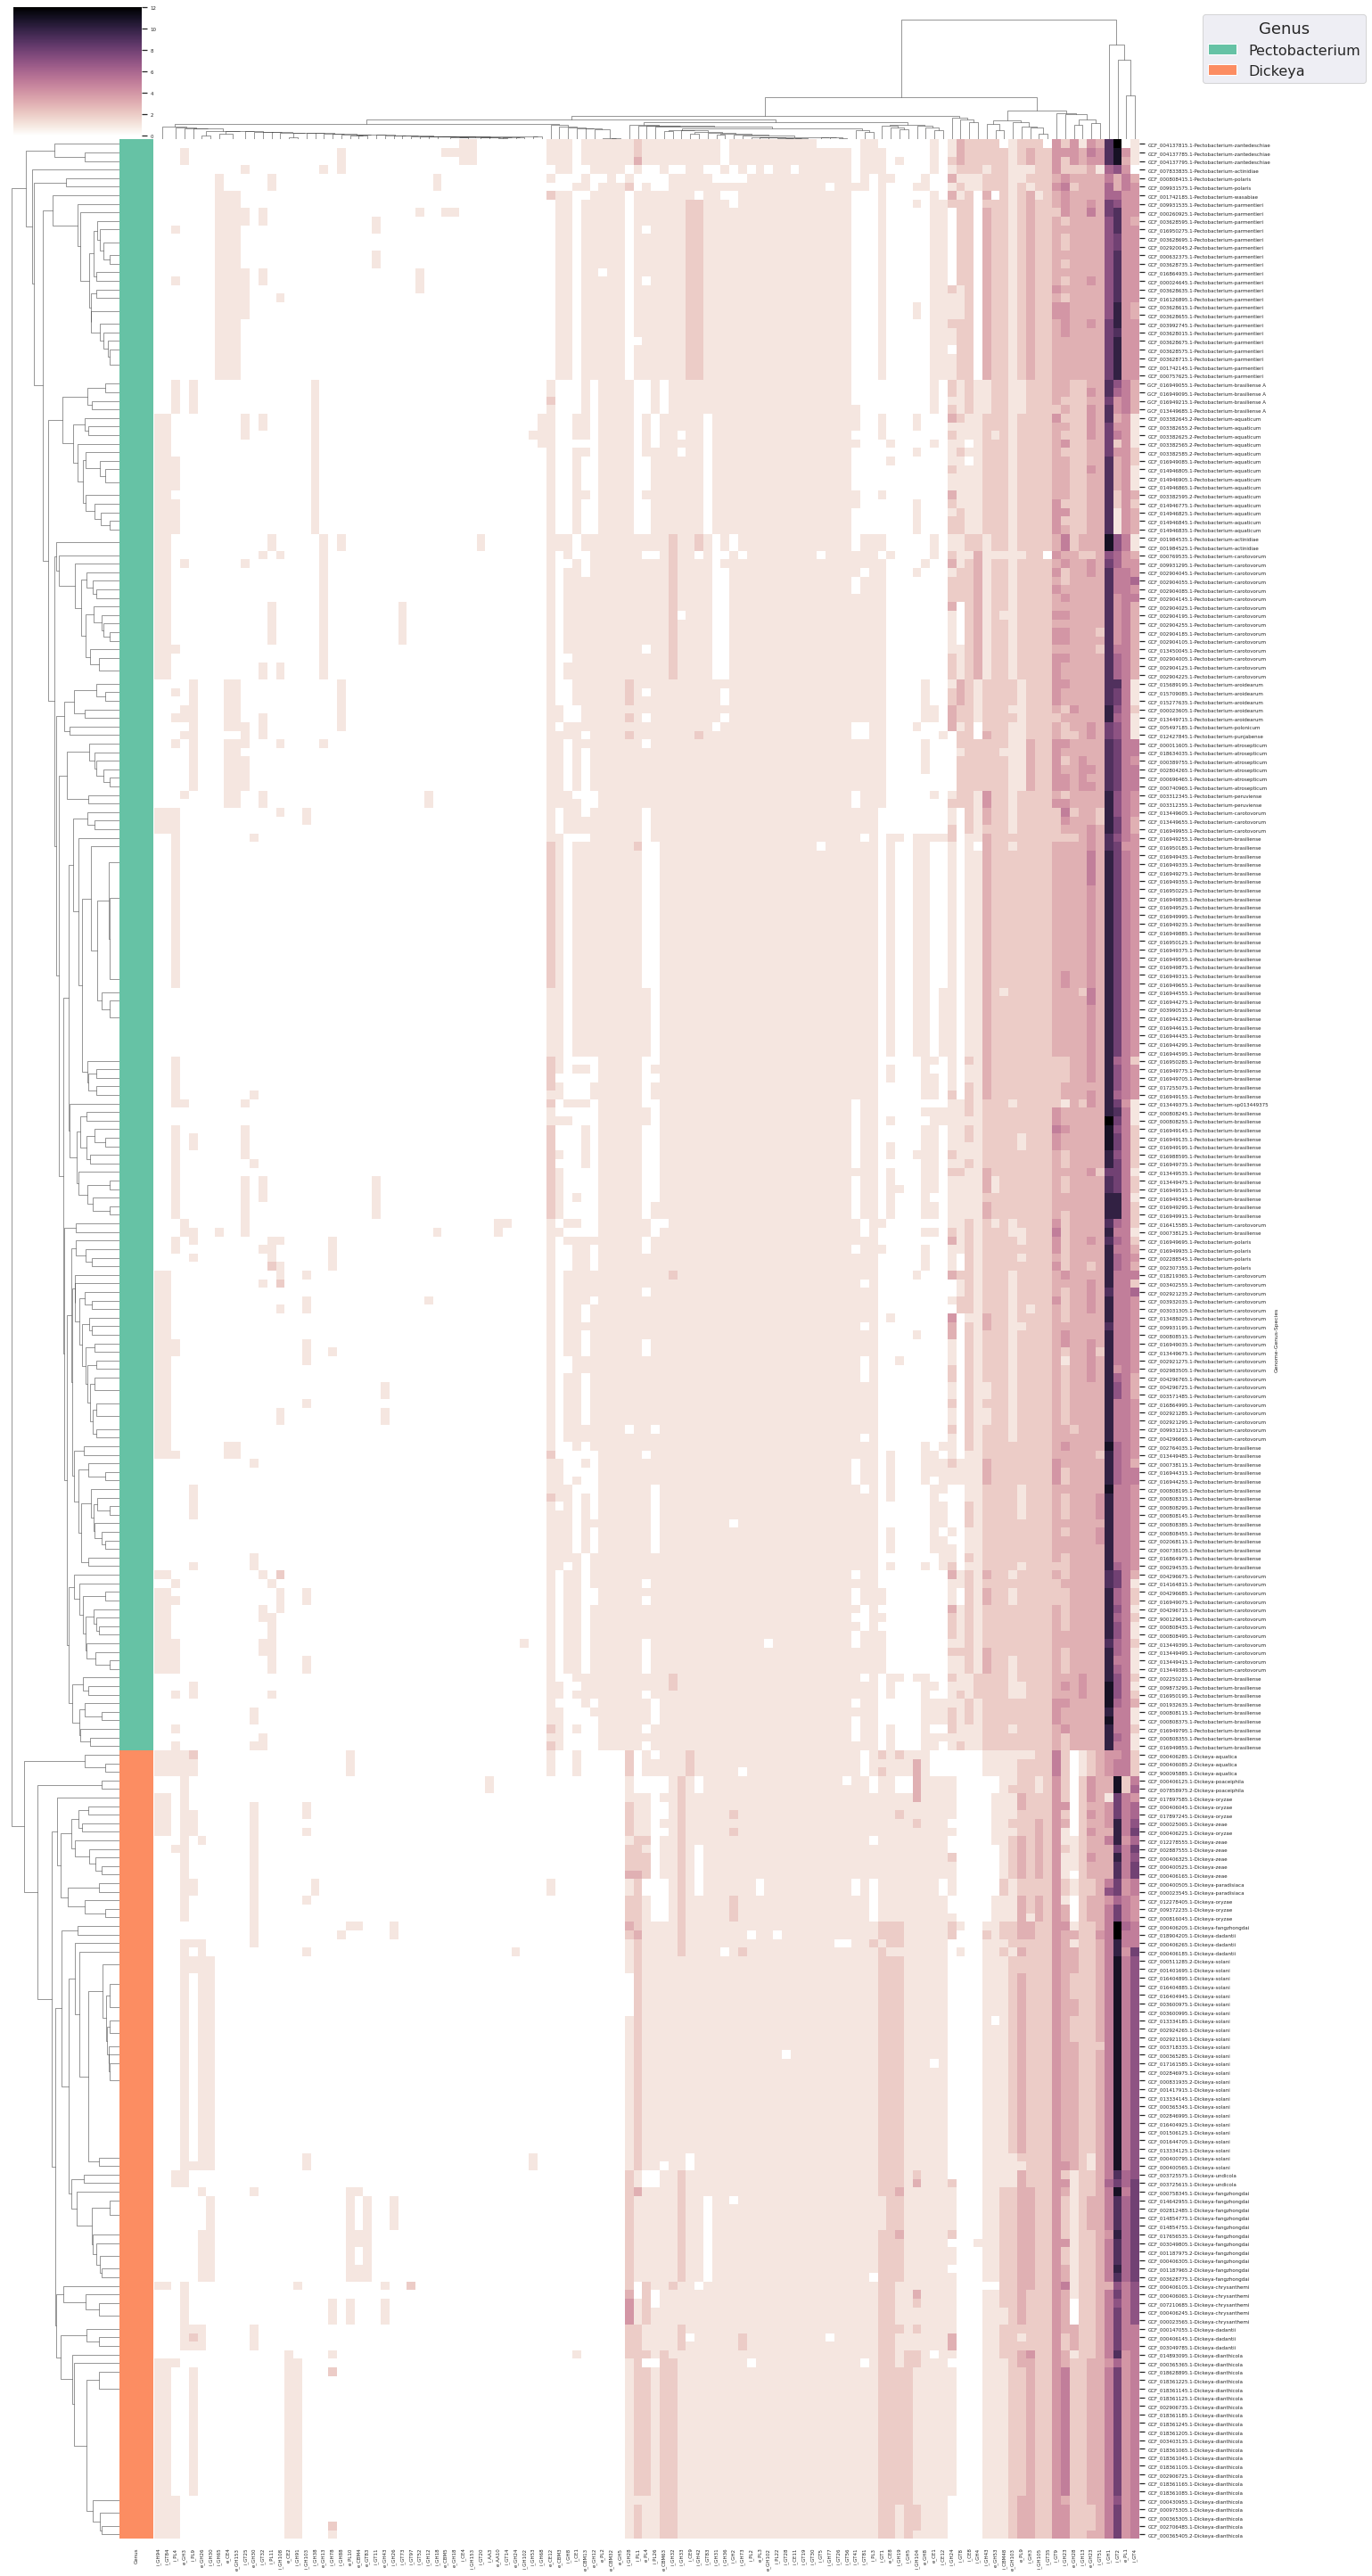

In [28]:
# make a figure the optimal size to fit in a paper
build_family_clustermap(
    fam_freq_df_ggs,
    row_colours=fam_freq_genus_row_colours,
    fig_size=(20,40),
    file_path=output_dir/"cazy_families/paper_pd_IE_fam_freq_clustermap.png",
    file_format='png',
    font_scale=0.5,
    lut=fam_g_lut,
    legend_title='Genus',
    dendrogram_ratio=(0.1,0.05),
    title_fontsize=18,
    legend_fontsize=16,
    cbar_pos=(0.01, 0.95, 0.1, 0.05),  #left, bottom, width, height
)

### Add species classifications

Looking at the species names in the clustermap, there appears to be clustering of the genomes in a manner that correlates not only with their genus classificaiton but also their species classification. Therefore, add an additional row of row-colours, marking the species classification of each genome.

In [29]:
# define a colour scheme to colour code rows by SPECIES
fam_freq_df_ggs['Species'] = list(fam_freq_df['Species'])  # add column to use for colour scheme, is removed
fam_freq_species_row_colours, fam_s_lut = build_row_colours(fam_freq_df_ggs, 'Species', 'rainbow')

/home/emmah/.conda/envs/pectobacteriaceae/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/emmah/.conda/envs/pectobacteriaceae/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


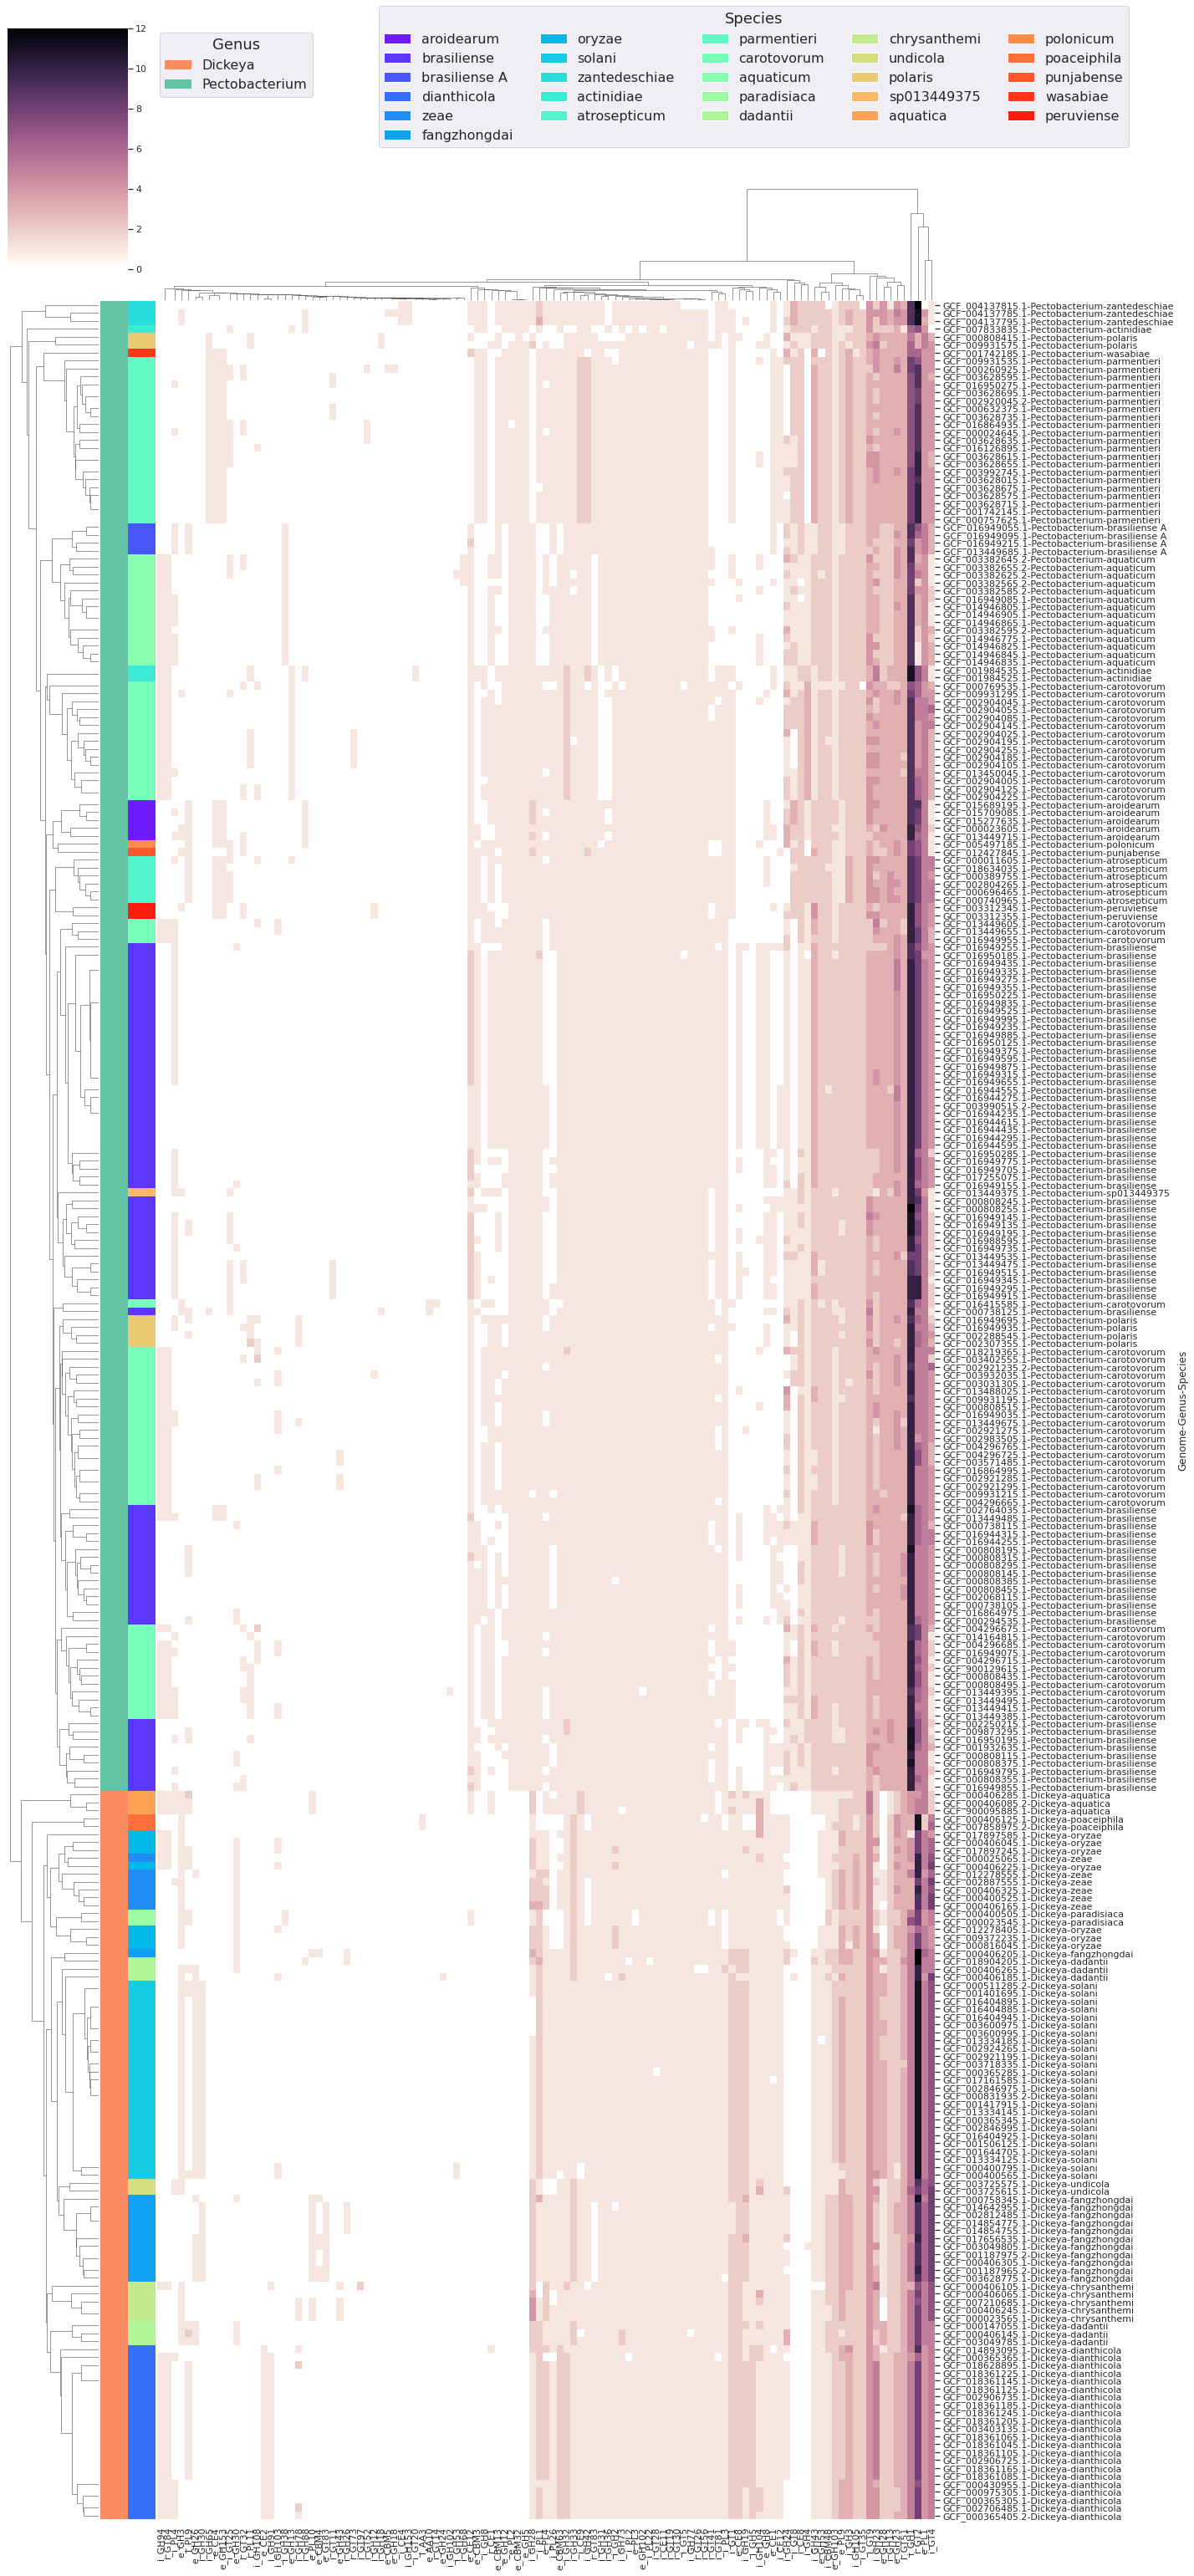

In [30]:
# make a figure the optimal size to fit in a paper
build_family_clustermap_multi_legend(
    df=fam_freq_df_ggs,
    row_colours=[fam_freq_genus_row_colours,fam_freq_species_row_colours],
    luts=[fam_g_lut, fam_s_lut],
    legend_titles=['Genus', 'Species'],
    bbox_to_anchors=[(0.2,1.045), (0.63,1.04)],
    legend_cols=[1,5],
    fig_size=(20,40),
    file_path=output_dir/"cazy_families/paper_pd_IE_genus_species_fam_freq_clustermap.png",
    file_format='png',
    font_scale=1,
    dendrogram_ratio=(0.1,0.05),
    title_fontsize=18,
    legend_fontsize=16,
    cbar_pos=(0.01, 0.96, 0.1, 0.1),  #left, bottom, width, height
)

/home/emmah/.conda/envs/pectobacteriaceae/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/emmah/.conda/envs/pectobacteriaceae/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


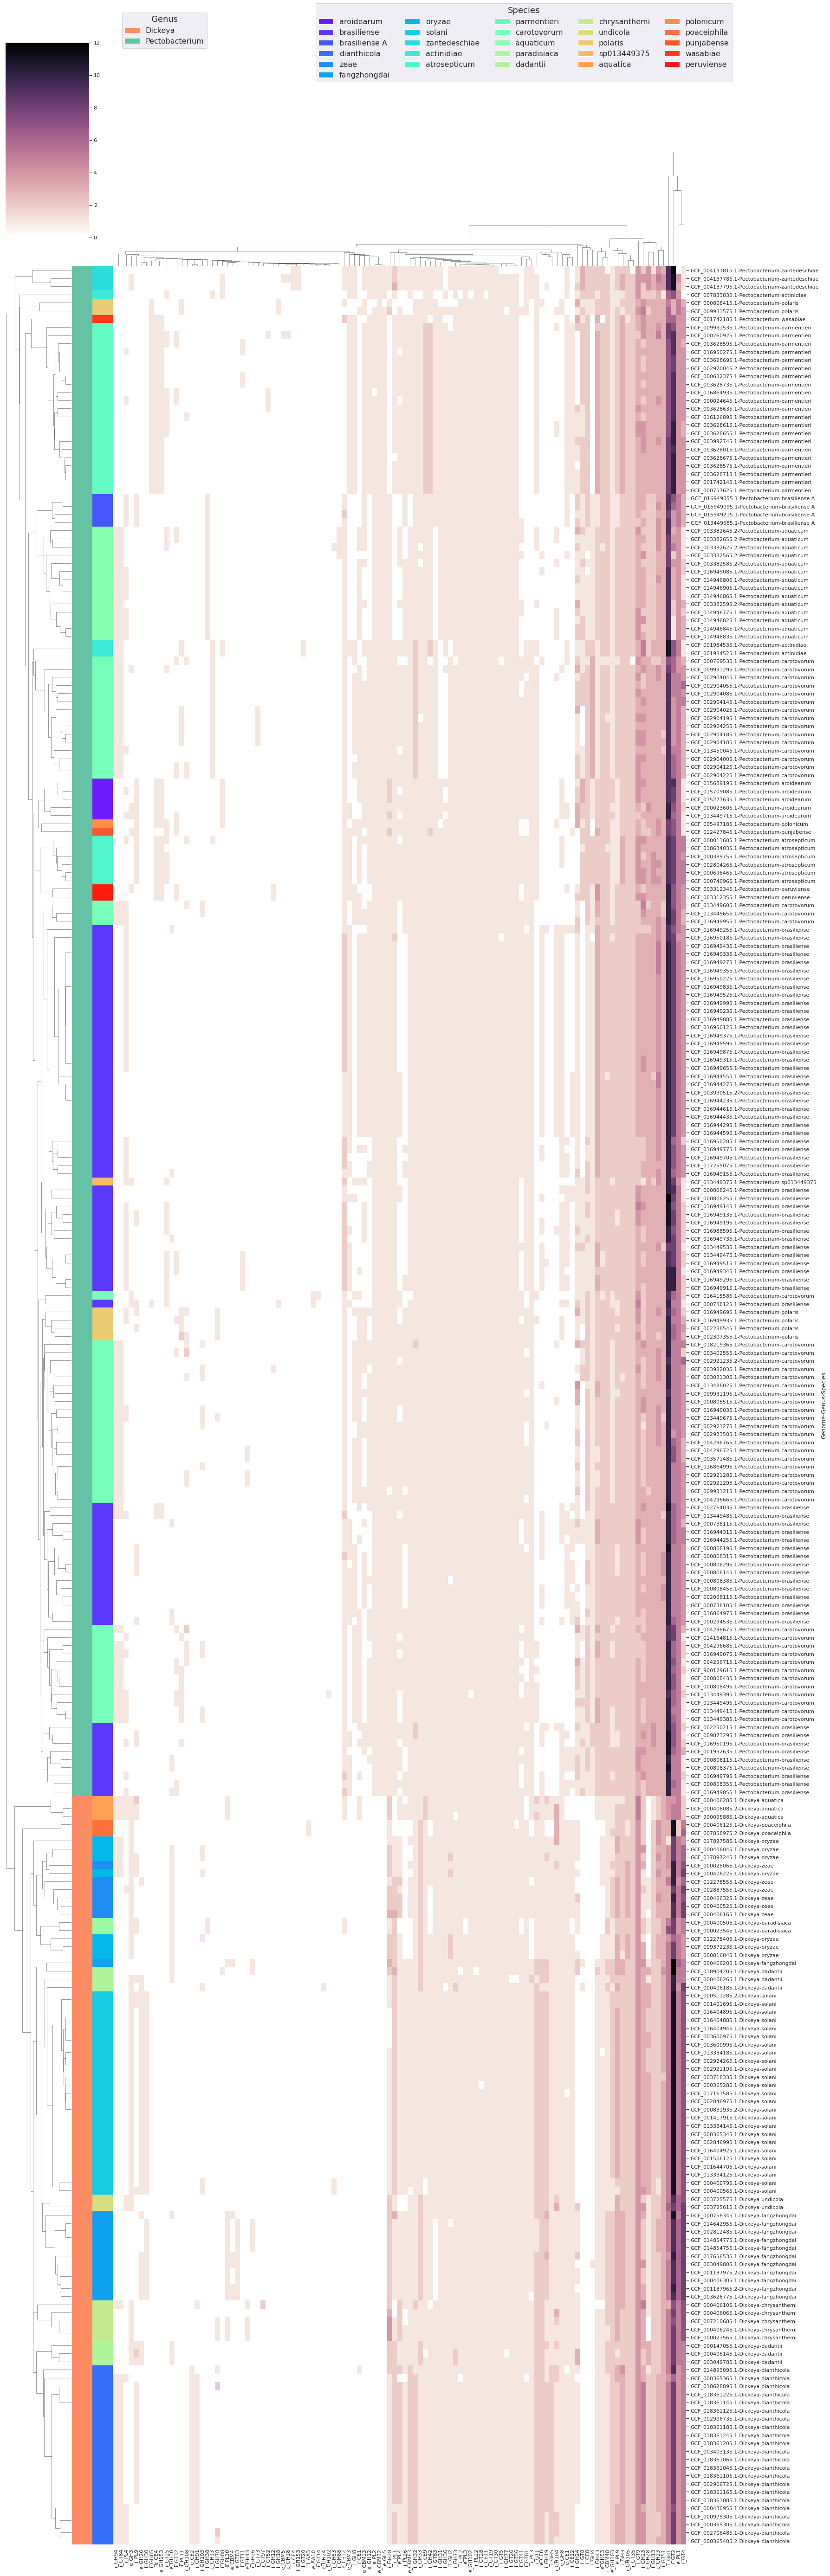

In [31]:
# make a figure the optimal size to fit in a paper
build_family_clustermap_multi_legend(
    df=fam_freq_df_ggs,
    row_colours=[fam_freq_genus_row_colours,fam_freq_species_row_colours],
    luts=[fam_g_lut, fam_s_lut],
    legend_titles=['Genus', 'Species'],
    bbox_to_anchors=[(0.2,1.045), (0.63,1.04)],
    legend_cols=[1,5],
    fig_size=(25,73),
    file_path=output_dir/"cazy_families/pd_IE_genus_species_fam_freq_clustermap.svg",
    file_format='svg',
    font_scale=1,
    dendrogram_ratio=(0.1,0.05),
    title_fontsize=18,
    legend_fontsize=16,
    cbar_pos=(0.01, 0.96, 0.1, 0.08),  #left, bottom, width, height
)

<a id="core-cazome"> </a>
## 4. The Core CAZome

Identify CAzy families that are present in every genome in the dataset using `identify_core_cazome()`, which takes the dataframe of CAZy family frequencies (with only CAZy families included in the columns, i.e no taxonomy columns). These families form the 'core CAZome'.

In [32]:
core_cazome = identify_core_cazome(fam_freq_df_ggs)

core_cazome = list(core_cazome)
core_cazome.sort()

print("The core CAZy families are:")
for fam in core_cazome:
    print('-', fam)

Identifying core CAZome: 100%|██████████| 113/113 [00:00<00:00, 7080.10it/s]

The core CAZy families are:
- e_GH103
- e_GH23
- e_PL9
- i_GH1
- i_GH105
- i_GH13
- i_GH23
- i_GH3
- i_GT19
- i_GT2
- i_GT30
- i_GT51
- i_GT9


Build a one-dimensional box plot, using `plot_fam_boxplot()`, which plots the frequency of each CAZy family in the core CAZome across the dataset.

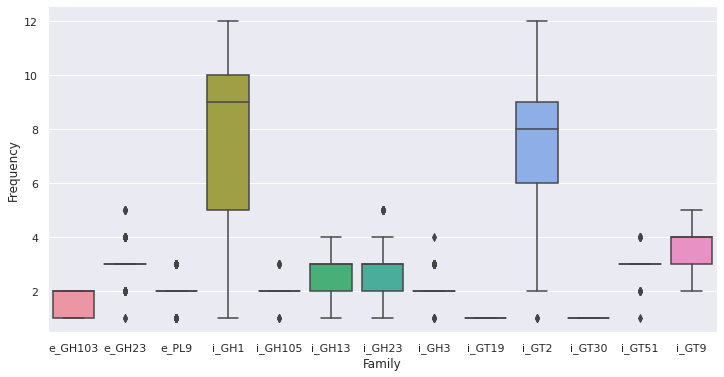

In [33]:
# filter the famil freq df to include only those families in the core CAZome
core_cazome_df = fam_freq_df_ggs[core_cazome]
plot_fam_boxplot(core_cazome_df, font_scale=0.8, fig_size=(12,6))

The boxplot shows the frequency of each CAZy family across all genomes in the dataframe. We can also break down this data by genus, and build a dataframe of Family, Genus (or tax rank of choice), genome, and frequency.

This dataframe can then be used to build a second dataframe of:
* Family
* Tax rank
* Mean frequency
* SD frequency
Which can be presented as is in a report, or imported into [RawGraphs](https://app.rawgraphs.io/) to build a matrix plot (aka a proporitonal area plot).

In [34]:
core_cazome_df_genus = copy(core_cazome_df)  # to ensure core_cazome_df is not altereted
core_cazome_df_genus = add_tax_column_from_row_index(core_cazome_df_genus, 'Genus', 1)
core_cazome_df_genus.head(1)

e_GH103  e_GH23  e_PL9  i_GH1   
Genome          Genus          Species                                     
GCF_000023605.1 Pectobacterium aroidearum        1       3      1     10  \

                                           i_GH105  i_GH13  i_GH23  i_GH3   
Genome          Genus          Species                                      
GCF_000023605.1 Pectobacterium aroidearum        2       3       2      2  \

                                           i_GT19  i_GT2  i_GT30  i_GT51   
Genome          Genus          Species                                     
GCF_000023605.1 Pectobacterium aroidearum       1      7       1       3  \

                                           i_GT9           Genus  
Genome          Genus          Species                            
GCF_000023605.1 Pectobacterium aroidearum      3  Pectobacterium

In [35]:
core_cazome_fggf_df, core_cazome_mean_freq_df = build_fam_mean_freq_df(
    core_cazome_df_genus,
    'Genus',
    round_by=2,
)
make_output_directory(output_dir/"core_cazome/", nodelete=True, force=True)
core_cazome_mean_freq_df.to_csv(output_dir/"core_cazome/IE_core_cazome_freqs.csv")

core_cazome_mean_freq_df

Building [Fam, grp, mean freq, sd freq] df: 100%|██████████| 2/2 [00:00<00:00, 61.04it/s]
Output directory ../results/pecto_dic/ie_cazymes/core_cazome exists, nodelete is True. Adding output to output directory.


Family           Genus  MeanFreq  SdFreq
0   e_GH103         Dickeya      1.80    0.40
1    e_GH23         Dickeya      2.45    0.65
2     e_PL9         Dickeya      2.61    0.55
3     i_GH1         Dickeya      4.72    0.77
4   i_GH105         Dickeya      2.09    0.35
5    i_GH13         Dickeya      1.97    0.18
6    i_GH23         Dickeya      3.10    1.12
7     i_GH3         Dickeya      2.38    0.55
8    i_GT19         Dickeya      1.00    0.00
9     i_GT2         Dickeya      9.12    1.67
10   i_GT30         Dickeya      1.00    0.00
11   i_GT51         Dickeya      3.00    0.15
12    i_GT9         Dickeya      4.03    0.18
13  e_GH103  Pectobacterium      1.41    0.49
14   e_GH23  Pectobacterium      3.36    0.58
15    e_PL9  Pectobacterium      1.82    0.38
16    i_GH1  Pectobacterium      9.32    1.13
17  i_GH105  Pectobacterium      1.99    0.07
18   i_GH13  Pectobacterium      2.91    0.41
19   i_GH23  Pectobacterium      2.84    0.80
20    i_GH3  Pectobacterium      2.14    0.39
21   i_GT19  Pectobacterium      1.00    0.00
22    i_GT2  Pectobacterium      6.57    2.05
23   i_GT30  Pectobacterium      1.00    0.00
24   i_GT51  Pectobacterium      2.99    0.31
25    i_GT9  Pectobacterium      3.18    0.59

### Genus specific core CAZomes

The identification of the core CAZome was completed for all _Pectobacterium_ and _Dickeya_ genomes.

The datafame of genomes can be filtered to contain only genomes for one genus (or a tax rank of choice). Afterwhich, the core CAZome for a specfic genus (or tax rank of choice).

In [36]:
# add a tax rank (e.g. genus) column so that the genomes can be grouped by their tax rank
fam_freq_df_ggs_genus = copy(fam_freq_df_ggs)  # to ensure core_cazome_df is not altereted
fam_freq_df_ggs_genus = add_tax_column_from_row_index(fam_freq_df_ggs_genus, 'Genus', 1)
fam_freq_df_ggs_genus.head(1)

e_AA10  e_CBM13  e_CBM3  e_CBM32   
Genome          Genus          Species                                        
GCF_000023605.1 Pectobacterium aroidearum       0        1       1        1  \

                                           e_CBM4  e_CBM5  e_CBM63  e_CE1   
Genome          Genus          Species                                      
GCF_000023605.1 Pectobacterium aroidearum       0       0        1      1  \

                                           e_CE12  e_CE2  ...  i_GT97  i_PL1   
Genome          Genus          Species                    ...                  
GCF_000023605.1 Pectobacterium aroidearum       1      0  ...       0      1  \

                                           i_PL11  i_PL2  i_PL22  i_PL26   
Genome          Genus          Species                                     
GCF_000023605.1 Pectobacterium aroidearum       0      1       1       1  \

                                           i_PL3  i_PL4  i_PL9           Genus  
Genome          Genus          Species                                          
GCF_000023605.1 Pectobacterium aroidearum      1      0      1  Pectobacterium  

[1 rows x 114 columns]

<a id="pecto-core-cazome"> </a>
### _Pectobacterium_ Core CAZome

In [37]:
# filter for only pectobacterium genomes
pecto_freq_df_ggs_genus = fam_freq_df_ggs_genus[fam_freq_df_ggs_genus['Genus'] == 'Pectobacterium']
print(f"Analysing {len(pecto_freq_df_ggs_genus)} Pectobacterium genomes")

# Identify the core CAZome
pecto_core_cazome = identify_core_cazome(pecto_freq_df_ggs_genus)
print("The core CAZy families in Pectobacterium are:")
pecto_core_cazome = list(pecto_core_cazome)
pecto_core_cazome.sort()
for fam in pecto_core_cazome:
    print('-', fam)

Analysing 188 Pectobacterium genomes


Identifying core CAZome: 100%|██████████| 114/114 [00:00<00:00, 6351.80it/s]

The core CAZy families in Pectobacterium are:
- Genus
- e_CBM32
- e_GH103
- e_GH23
- e_GH28
- e_PL3
- e_PL9
- i_CE9
- i_GH1
- i_GH105
- i_GH13
- i_GH23
- i_GH3
- i_GH43
- i_GT19
- i_GT2
- i_GT28
- i_GT30
- i_GT51
- i_GT9
- i_PL22


<a id="dic-core-cazome"> </a>
### _Dickeya_ Core CAZome

In [38]:
# filter for only dickeya genomes
dic_freq_df_ggs_genus = fam_freq_df_ggs_genus[fam_freq_df_ggs_genus['Genus'] == 'Dickeya']
print(f"Analysing {len(dic_freq_df_ggs_genus)} Dickeya genomes")

# Identify the core CAZome
dic_core_cazome = identify_core_cazome(dic_freq_df_ggs_genus)
print("The core CAZy families in Dickeya are:")
dic_core_cazome = list(dic_core_cazome)
dic_core_cazome.sort()
for fam in dic_core_cazome:
    print('-', fam)

Analysing 92 Dickeya genomes


Identifying core CAZome: 100%|██████████| 114/114 [00:00<00:00, 6803.12it/s]

The core CAZy families in Dickeya are:
- Genus
- e_CE8
- e_GH102
- e_GH103
- e_GH23
- e_GH8
- e_PL1
- e_PL9
- i_CBM48
- i_CE11
- i_GH1
- i_GH104
- i_GH105
- i_GH13
- i_GH23
- i_GH3
- i_GH31
- i_GH32
- i_GH33
- i_GT1
- i_GT19
- i_GT2
- i_GT30
- i_GT35
- i_GT4
- i_GT5
- i_GT51
- i_GT9


### Combine the mean core CAZy family frequencies

For the genus specific families, calculate the mean frequency across the genomes using `build_fam_mean_freq_df()`, and append the resulting data to the `core_cazome_mean_freq_df` dataframe.

Additionally, arrange the data so that the intracellular-extracellular family pairs are next to each other.

In [39]:
core_cazome_mean_freq_df.head(1)

Family    Genus  MeanFreq  SdFreq
0  e_GH103  Dickeya       1.8     0.4

In [40]:
dic_freq_df_ggs_genus.head(1)
dic_only_core_fams = [fam for fam in dic_core_cazome if fam not in core_cazome]
dic_freq_df_ggs_genus_core_cazome = dic_freq_df_ggs_genus[dic_only_core_fams]

d_core_cazome_fggf_df, d_core_cazome_mean_freq_df = build_fam_mean_freq_df(
    dic_freq_df_ggs_genus_core_cazome,
    'Genus',
    round_by=2,
)

pecto_freq_df_ggs_genus.head(1)
pecto_only_core_fams = [fam for fam in pecto_core_cazome if fam not in core_cazome]
pecto_freq_df_ggs_genus_core_cazome = pecto_freq_df_ggs_genus[pecto_only_core_fams]

p_core_cazome_fggf_df, p_core_cazome_mean_freq_df = build_fam_mean_freq_df(
    pecto_freq_df_ggs_genus_core_cazome,
    'Genus',
    round_by=2,
)

pd_core_cazome_mean_freq_df = copy(core_cazome_mean_freq_df)
pd_core_cazome_mean_freq_df = pd.concat(
    [pd_core_cazome_mean_freq_df, d_core_cazome_mean_freq_df],
    ignore_index=True,
)
pd_core_cazome_mean_freq_df = pd.concat(
    [pd_core_cazome_mean_freq_df, p_core_cazome_mean_freq_df],
    ignore_index=True,
)

pd_core_cazome_mean_freq_df.to_csv(output_dir/"core_cazome/pd_IE_all_core_cazome_freqs.csv")
pd_core_cazome_mean_freq_df

Building [Fam, grp, mean freq, sd freq] df: 100%|██████████| 1/1 [00:00<00:00, 49.91it/s]


Family           Genus  MeanFreq  SdFreq
0   e_GH103         Dickeya      1.80    0.40
1    e_GH23         Dickeya      2.45    0.65
2     e_PL9         Dickeya      2.61    0.55
3     i_GH1         Dickeya      4.72    0.77
4   i_GH105         Dickeya      2.09    0.35
5    i_GH13         Dickeya      1.97    0.18
6    i_GH23         Dickeya      3.10    1.12
7     i_GH3         Dickeya      2.38    0.55
8    i_GT19         Dickeya      1.00    0.00
9     i_GT2         Dickeya      9.12    1.67
10   i_GT30         Dickeya      1.00    0.00
11   i_GT51         Dickeya      3.00    0.15
12    i_GT9         Dickeya      4.03    0.18
13  e_GH103  Pectobacterium      1.41    0.49
14   e_GH23  Pectobacterium      3.36    0.58
15    e_PL9  Pectobacterium      1.82    0.38
16    i_GH1  Pectobacterium      9.32    1.13
17  i_GH105  Pectobacterium      1.99    0.07
18   i_GH13  Pectobacterium      2.91    0.41
19   i_GH23  Pectobacterium      2.84    0.80
20    i_GH3  Pectobacterium      2.14    0.39
21   i_GT19  Pectobacterium      1.00    0.00
22    i_GT2  Pectobacterium      6.57    2.05
23   i_GT30  Pectobacterium      1.00    0.00
24   i_GT51  Pectobacterium      2.99    0.31
25    i_GT9  Pectobacterium      3.18    0.59
26    e_CE8         Dickeya      1.77    0.42
27  e_GH102         Dickeya      1.00    0.00
28    e_GH8         Dickeya      1.00    0.00
29    e_PL1         Dickeya      4.79    0.76
30  i_CBM48         Dickeya      1.25    0.43
31   i_CE11         Dickeya      1.00    0.00
32  i_GH104         Dickeya      1.25    0.58
33   i_GH31         Dickeya      1.00    0.00
34   i_GH32         Dickeya      1.24    0.43
35   i_GH33         Dickeya      1.40    0.49
36    i_GT1         Dickeya      1.75    0.43
37   i_GT35         Dickeya      2.00    0.00
38    i_GT4         Dickeya      6.17    1.45
39    i_GT5         Dickeya      1.00    0.00
40  e_CBM32  Pectobacterium      1.00    0.00
41   e_GH28  Pectobacterium      2.88    0.38
42    e_PL3  Pectobacterium      1.00    0.00
43    i_CE9  Pectobacterium      1.11    0.31
44   i_GH43  Pectobacterium      2.26    0.70
45   i_GT28  Pectobacterium      1.00    0.00
46   i_PL22  Pectobacterium      1.00    0.00

In [42]:
# add col with the cazy fam annotation without i_ and e_ prefix
pd_core_cazome_mean_freq_df['Parent Family'] = [fam.split("_")[-1] for fam in pd_core_cazome_mean_freq_df['Family']]

# fams in both
# pect only
# dickeya only
pec_in = []
pec_ex = []
pec_both = []

dic_in = []
dic_ex = []
dic_both = []

both_in = []
both_ex = []
both_both = []

for fam in set(pd_core_cazome_mean_freq_df['Parent Family']):
    rows = pd_core_cazome_mean_freq_df[pd_core_cazome_mean_freq_df['Parent Family'] == fam]
    
    if len(rows) == 1:
        genus = rows['Genus'].values[0]
        ie_fam = rows['Family'].values[0]
        
        if ie_fam.startswith('i'):  # Intracellular
            if genus == 'Pectobacterium':
                pec_in.append(list(rows.iloc[0]))
            else:
                dic_in.append(list(rows.iloc[0]))
        
        else:  # Extracellular
            if genus == 'Pectobacterium':
                pec_ex.append(list(rows.iloc[0]))
            else:
                dic_ex.append(list(rows.iloc[0]))
        
        continue
    
    # check if one genus
    if len(set(rows['Genus'])) == 1:
        print('**************')
        continue
        # no core families are I and E in a single genus
        
    # check if exclusively I or E
    if len(set(rows['Family'])) == 1:
        for i in range(len(rows)):
            ie_fam = rows.iloc[i]['Family']
            
            if ie_fam.startswith('i'):  # Intracellular in both genera
                both_in.append(list(rows.iloc[i]))

            else:  # Extracellular in both genera
                both_ex.append(list(rows.iloc[i]))
        continue
    
    # both I and E in both genera
    else:  
        for i in range(len(rows)):
            both_both.append(list(rows.iloc[i]))
        continue
        
all_data = []
all_data.extend(both_both)
all_data.extend(both_in)
all_data.extend(both_ex)
all_data.extend(pec_both)
all_data.extend(pec_in)
all_data.extend(pec_ex)
all_data.extend(dic_both)
all_data.extend(dic_in)
all_data.extend(dic_ex)

ordered_core_cazome_df = pd.DataFrame(all_data, columns=['Family', 'Genus', 'Mean Frequency', 'SD', 'Parent Family'])
ie_col = [fam.split("_")[0] for fam in ordered_core_cazome_df['Family']]
for i in range(len(ie_col)):
    if ie_col[i] == 'i':
        ie_col[i] = 'Intracellular'
    else:
        ie_col[i] = 'Extracellular'
ordered_core_cazome_df['IE'] = ie_col
ordered_core_cazome_df.to_csv(output_dir/"core_cazome/pd_IE_all_core_cazome_freqs_ordered.csv")
ordered_core_cazome_df

Family           Genus  Mean Frequency    SD Parent Family             IE
0    e_GH23         Dickeya            2.45  0.65          GH23  Extracellular
1    i_GH23         Dickeya            3.10  1.12          GH23  Intracellular
2    e_GH23  Pectobacterium            3.36  0.58          GH23  Extracellular
3    i_GH23  Pectobacterium            2.84  0.80          GH23  Intracellular
4    i_GT30         Dickeya            1.00  0.00          GT30  Intracellular
5    i_GT30  Pectobacterium            1.00  0.00          GT30  Intracellular
6     i_GH1         Dickeya            4.72  0.77           GH1  Intracellular
7     i_GH1  Pectobacterium            9.32  1.13           GH1  Intracellular
8    i_GT51         Dickeya            3.00  0.15          GT51  Intracellular
9    i_GT51  Pectobacterium            2.99  0.31          GT51  Intracellular
10    i_GT2         Dickeya            9.12  1.67           GT2  Intracellular
11    i_GT2  Pectobacterium            6.57  2.05           GT2  Intracellular
12  i_GH105         Dickeya            2.09  0.35         GH105  Intracellular
13  i_GH105  Pectobacterium            1.99  0.07         GH105  Intracellular
14    i_GH3         Dickeya            2.38  0.55           GH3  Intracellular
15    i_GH3  Pectobacterium            2.14  0.39           GH3  Intracellular
16   i_GH13         Dickeya            1.97  0.18          GH13  Intracellular
17   i_GH13  Pectobacterium            2.91  0.41          GH13  Intracellular
18    i_GT9         Dickeya            4.03  0.18           GT9  Intracellular
19    i_GT9  Pectobacterium            3.18  0.59           GT9  Intracellular
20   i_GT19         Dickeya            1.00  0.00          GT19  Intracellular
21   i_GT19  Pectobacterium            1.00  0.00          GT19  Intracellular
22    e_PL9         Dickeya            2.61  0.55           PL9  Extracellular
23    e_PL9  Pectobacterium            1.82  0.38           PL9  Extracellular
24  e_GH103         Dickeya            1.80  0.40         GH103  Extracellular
25  e_GH103  Pectobacterium            1.41  0.49         GH103  Extracellular
26    i_CE9  Pectobacterium            1.11  0.31           CE9  Intracellular
27   i_PL22  Pectobacterium            1.00  0.00          PL22  Intracellular
28   i_GH43  Pectobacterium            2.26  0.70          GH43  Intracellular
29   i_GT28  Pectobacterium            1.00  0.00          GT28  Intracellular
30    e_PL3  Pectobacterium            1.00  0.00           PL3  Extracellular
31  e_CBM32  Pectobacterium            1.00  0.00         CBM32  Extracellular
32   e_GH28  Pectobacterium            2.88  0.38          GH28  Extracellular
33  i_CBM48         Dickeya            1.25  0.43         CBM48  Intracellular
34   i_CE11         Dickeya            1.00  0.00          CE11  Intracellular
35   i_GH33         Dickeya            1.40  0.49          GH33  Intracellular
36    i_GT4         Dickeya            6.17  1.45           GT4  Intracellular
37    i_GT5         Dickeya            1.00  0.00           GT5  Intracellular
38   i_GH31         Dickeya            1.00  0.00          GH31  Intracellular
39    i_GT1         Dickeya            1.75  0.43           GT1  Intracellular
40   i_GH32         Dickeya            1.24  0.43          GH32  Intracellular
41   i_GT35         Dickeya            2.00  0.00          GT35  Intracellular
42  i_GH104         Dickeya            1.25  0.58         GH104  Intracellular
43    e_PL1         Dickeya            4.79  0.76           PL1  Extracellular
44    e_CE8         Dickeya            1.77  0.42           CE8  Extracellular
45  e_GH102         Dickeya            1.00  0.00         GH102  Extracellular
46    e_GH8         Dickeya            1.00  0.00           GH8  Extracellular

In [43]:
len(pd_core_cazome_mean_freq_df)

47

In [44]:
len(ordered_core_cazome_df)

47

<a id="co-occurring"> </a>
## 5. Families that always occur together

Identify CAZy families that are always present in the genome together - this approach does not tolerate one CAZy family ever appearing without the other family in the same genome.

In [45]:
make_output_directory(output_dir/"cooccurring_families/", force=True, nodelete=True)
# reminder of the structure of the df
fam_freq_df.columns

Output directory ../results/pecto_dic/ie_cazymes/cooccurring_families exists, nodelete is True. Adding output to output directory.


Index(['Genome', 'Genus', 'Species', 'e_AA10', 'e_CBM13', 'e_CBM3', 'e_CBM32',
       'e_CBM4', 'e_CBM5', 'e_CBM63',
       ...
       'i_GT9', 'i_GT97', 'i_PL1', 'i_PL11', 'i_PL2', 'i_PL22', 'i_PL26',
       'i_PL3', 'i_PL4', 'i_PL9'],
      dtype='object', length=116)

**An iterative approach to identify co-occurring families:**

Iterate through the dataframe of CAZy family frequencies in _Pectobacterium_ and _Dickeya_ (`fam_freq_df_pd`) and identify the groups of always co-occurring CAZy families (i.e. those families that are always present together) and count the number of genomes in which the families are present together.

This is done using the `cazomevolve` function `calc_cooccuring_fam_freqs`, which returns a dictionary of groups of co-occurring CAZy families. The function takes as input:
1. The dataframe of CAZy family frequencies (it can include taxonomy information in columns)
2. A list of the CAZy families to analyse
3. (Optional) whether to include or exclude the core CAZome from the list of always co-occurring CAZy families.

In [46]:
cooccurring_fams_dict = calc_cooccuring_fam_freqs(
    fam_freq_df,
    list(fam_freq_df.columns[3:]),
    exclude_core_cazome=False,
)
cooccurring_fams_dict

Combining pairs of co-occurring families: 100%|██████████| 86/86 [00:00<00:00, 325844.76it/s]


{0: {'fams': {'e_CBM5', 'e_GH18'}, 'freqs': {2}},
 1: {'fams': {'e_CE4', 'e_GH153'}, 'freqs': {38}},
 2: {'fams': {'e_GH103',
   'e_GH23',
   'e_PL9',
   'i_GH1',
   'i_GH105',
   'i_GH13',
   'i_GH23',
   'i_GH3',
   'i_GT19',
   'i_GT2',
   'i_GT30',
   'i_GT51',
   'i_GT9'},
  'freqs': {280}},
 3: {'fams': {'e_PL1', 'i_CBM48'}, 'freqs': {279}},
 4: {'fams': {'i_CE11', 'i_GH32', 'i_GT4'}, 'freqs': {279}},
 5: {'fams': {'i_CE4', 'i_GH153'}, 'freqs': {3}},
 6: {'fams': {'i_GH94', 'i_GT84'}, 'freqs': {97}}}

Identify groups of co-occurring families in only _Pectobacterium_ or _Dickeya_ genomes.

In [47]:
# Pectobacterium
pecto_fam_freq_df = fam_freq_df[fam_freq_df['Genus'] == 'Pectobacterium']
pecto_cooccurring_fams_dict = calc_cooccuring_fam_freqs(pecto_fam_freq_df, list(pecto_fam_freq_df.columns[3:]), exclude_core_cazome=False)
pecto_cooccurring_fams_dict

Combining pairs of co-occurring families: 100%|██████████| 206/206 [00:00<00:00, 365184.54it/s]


{0: {'fams': {'e_CBM32',
   'e_GH103',
   'e_GH23',
   'e_GH28',
   'e_PL3',
   'e_PL9',
   'i_CE9',
   'i_GH1',
   'i_GH105',
   'i_GH13',
   'i_GH23',
   'i_GH3',
   'i_GH43',
   'i_GT19',
   'i_GT2',
   'i_GT28',
   'i_GT30',
   'i_GT51',
   'i_GT9',
   'i_PL22'},
  'freqs': {188}},
 1: {'fams': {'e_CBM5', 'e_GH18'}, 'freqs': {2}},
 2: {'fams': {'e_CE4', 'e_GH153'}, 'freqs': {38}},
 3: {'fams': {'e_PL1', 'i_CBM48', 'i_GT26', 'i_GT56'}, 'freqs': {187}},
 4: {'fams': {'i_CE11', 'i_GH32', 'i_GT4', 'i_PL2'}, 'freqs': {187}},
 5: {'fams': {'i_CE4', 'i_GH153'}, 'freqs': {3}},
 6: {'fams': {'i_GH94', 'i_GT84'}, 'freqs': {67}}}

In [48]:
# Dickeya
dic_fam_freq_df = fam_freq_df[fam_freq_df['Genus'] == 'Dickeya']
dic_cooccurring_fams_dict = calc_cooccuring_fam_freqs(dic_fam_freq_df, list(dic_fam_freq_df.columns[3:]), exclude_core_cazome=False)
dic_cooccurring_fams_dict

Combining pairs of co-occurring families: 100%|██████████| 354/354 [00:00<00:00, 485382.03it/s]


{0: {'fams': {'e_CE8',
   'e_GH102',
   'e_GH103',
   'e_GH23',
   'e_GH8',
   'e_PL1',
   'e_PL9',
   'i_CBM48',
   'i_CE11',
   'i_GH1',
   'i_GH104',
   'i_GH105',
   'i_GH13',
   'i_GH23',
   'i_GH3',
   'i_GH31',
   'i_GH32',
   'i_GH33',
   'i_GT1',
   'i_GT19',
   'i_GT2',
   'i_GT30',
   'i_GT35',
   'i_GT4',
   'i_GT5',
   'i_GT51',
   'i_GT9'},
  'freqs': {92}},
 1: {'fams': {'e_PL3', 'i_GT41'}, 'freqs': {90}},
 2: {'fams': {'i_GH19', 'i_GH5'}, 'freqs': {90}},
 3: {'fams': {'i_GH94', 'i_GT84'}, 'freqs': {30}}}

### Build an upset plot of co-occurring CAZy families

Build an upsetplot (using the Python package `upsetplot`) to visulise the groups of always co-occurring CAZy families, additionally it will plot the number of genomes in which each group of co-occurring CAZy families were present.

First compile the data/membership for the upset plot by:
1. Creating an empty list to store the upset plot data
2. Adding to the empty list the data contained in each dictionary of co-occurring CAZy families by using the `add_to_upsetplot_membership()` function

In [49]:
upsetplot_membership = []
upsetplot_membership = add_to_upsetplot_membership(upsetplot_membership, cooccurring_fams_dict)
upsetplot_membership = add_to_upsetplot_membership(upsetplot_membership, pecto_cooccurring_fams_dict)
upsetplot_membership = add_to_upsetplot_membership(upsetplot_membership, dic_cooccurring_fams_dict)
len(upsetplot_membership)

1952

Build the upset plot.

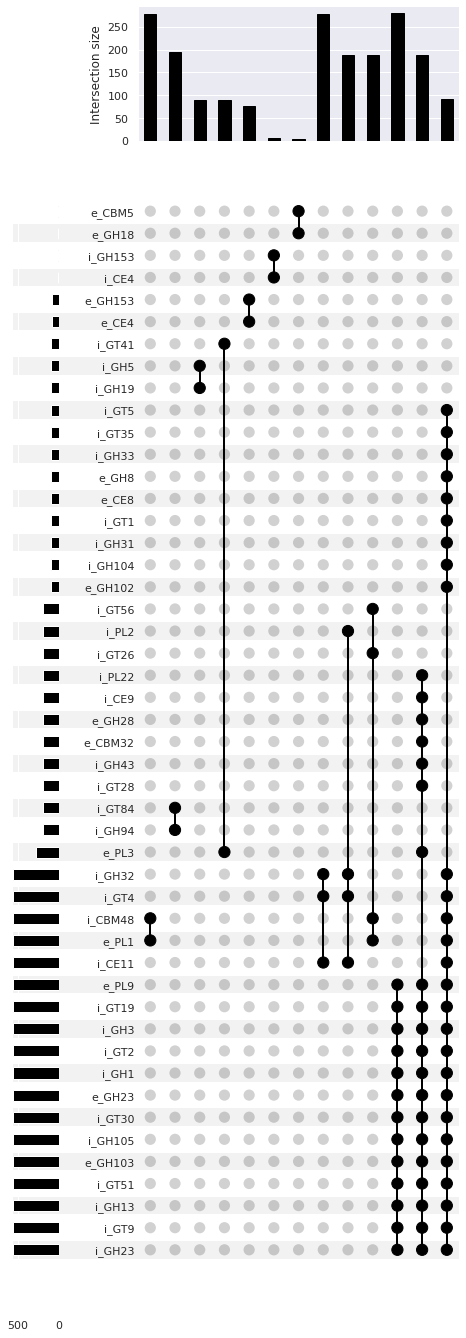

In [51]:
pecto_dic_upsetplot = build_upsetplot(
    upsetplot_membership,
    file_path=output_dir/'cooccurring_families/pd_cooccurring_fams.svg',
)

**Break down the incidences per genus:**

The upset plot generates a bar chart showing the number of genomes that each group of co-occuring CAZy families appeared in. However, this plots the total number across each of the groups (i.e. _Pectobacterium_, _Dickeya_, and both).

To break down the indidence (i.e. the number of genomes that each group of co-occurring CAZy families were present in) per group, a dataframe listing each group of co-occurring CAZy families, the group (i.e. genus), and the respective frequency must be generated. This dataframe can then be used to generate a proportional area plot (or matrix plot), breaking down the incidence per group (i.e. genus).

The groups of co-occurring CAZy families must be listed in the same order as they are presented in the upset plot.

In [52]:
upset_plot_groups = get_upsetplot_grps(upsetplot_membership)

100%|██████████| 13/13 [00:00<00:00, 58.37it/s]


Compiling the data of the incidence of each grp of co-occurring CAZy families per group of interest (e.g. per genus), into a single dataframe.

Create an empty list to store all data for the dataframe, then use `add_upsetplot_grp_freqs` to add data of the incidence per group of co-occurring CAZy families to the list. `build_upsetplot_matrix` is then used to build the dataframe.

In [53]:
cooccurring_grp_freq_data = []  # empty list to store data for the df

for fam_grp in upset_plot_groups:
    added = False
    
    for grp_num in cooccurring_fams_dict:
        fams = list(cooccurring_fams_dict[grp_num]['fams'])
        fams.sort()
        fam_grp = list(fam_grp)
        fam_grp.sort()
        if fams == fam_grp:
            freq = list(cooccurring_fams_dict[grp_num]['freqs'])[0]
            cooccurring_grp_freq_data.append(["+".join(fam_grp), 'Both', freq])
            added = True
    
    if added:
        continue
        
    # pecto_cooccurring_fams_dict
    for grp_num in pecto_cooccurring_fams_dict:
        fams = list(pecto_cooccurring_fams_dict[grp_num]['fams'])
        fams.sort()
        fam_grp = list(fam_grp)
        fam_grp.sort()
        if fams == fam_grp:
            freq = list(pecto_cooccurring_fams_dict[grp_num]['freqs'])[0]
            cooccurring_grp_freq_data.append(["+".join(fam_grp), 'Pectobacterium', freq])
            added = True
    
    if added:
        continue
    
    # dic_cooccurring_fams_dict
    for grp_num in dic_cooccurring_fams_dict:
        fams = list(dic_cooccurring_fams_dict[grp_num]['fams'])
        fams.sort()
        fam_grp = list(fam_grp)
        fam_grp.sort()
        if fams == fam_grp:
            freq = list(dic_cooccurring_fams_dict[grp_num]['freqs'])[0]
            cooccurring_grp_freq_data.append(["+".join(fam_grp), 'Dickeya', freq])
            added = True
    
    if added:
        continue

cooccurring_fams_freq_df = pd.DataFrame(cooccurring_grp_freq_data, columns=['Families', 'Genus', 'Incidence'])
cooccurring_fams_freq_df.to_csv(output_dir/'cooccurring_families/cooccurring_fams_freqs.csv')
cooccurring_fams_freq_df

Families           Genus   
0                                       e_PL1+i_CBM48            Both  \
1                                       i_GH94+i_GT84            Both   
2                                        i_GH19+i_GH5         Dickeya   
3                                        e_PL3+i_GT41         Dickeya   
4                                       e_CE4+e_GH153            Both   
5                                       i_CE4+i_GH153            Both   
6                                       e_CBM5+e_GH18            Both   
7                                 i_CE11+i_GH32+i_GT4            Both   
8                           i_CE11+i_GH32+i_GT4+i_PL2  Pectobacterium   
9                         e_PL1+i_CBM48+i_GT26+i_GT56  Pectobacterium   
10  e_GH103+e_GH23+e_PL9+i_GH1+i_GH105+i_GH13+i_GH...            Both   
11  e_CBM32+e_GH103+e_GH23+e_GH28+e_PL3+e_PL9+i_CE...  Pectobacterium   
12  e_CE8+e_GH102+e_GH103+e_GH23+e_GH8+e_PL1+e_PL9...         Dickeya   

    Incidence  
0         279  
1          97  
2          90  
3          90  
4          38  
5           3  
6           2  
7         279  
8         187  
9         187  
10        280  
11        188  
12         92

<a id="pca"></a>
## 6. Principal Component Analysis (PCA)

Use principal component analysis to identify individual and groups of CAZy families that are strongly associated with divergence between the composition of _Pectobacterium_ and _Dickeya_ CAZomes in terms of CAZy family frequencies. 

Use the `cazomevolve` function `perform_pca()` to perform a PCA on a dataframe where each row is a genome, and each column the frequency of a unique CAZy family - the columns in the dataframe must only contain numerical data (i.e. no taxonomic data).

In [56]:
# reminder of structure
fam_freq_df_ggs.head(1)

e_AA10  e_CBM13  e_CBM3  e_CBM32   
Genome          Genus          Species                                        
GCF_000023605.1 Pectobacterium aroidearum       0        1       1        1  \

                                           e_CBM4  e_CBM5  e_CBM63  e_CE1   
Genome          Genus          Species                                      
GCF_000023605.1 Pectobacterium aroidearum       0       0        1      1  \

                                           e_CE12  e_CE2  ...  i_GT9  i_GT97   
Genome          Genus          Species                    ...                  
GCF_000023605.1 Pectobacterium aroidearum       1      0  ...      3       0  \

                                           i_PL1  i_PL11  i_PL2  i_PL22   
Genome          Genus          Species                                    
GCF_000023605.1 Pectobacterium aroidearum      1       0      1       1  \

                                           i_PL26  i_PL3  i_PL4  i_PL9  
Genome          Genus          Species                                  
GCF_000023605.1 Pectobacterium aroidearum       1      1      0      1  

[1 rows x 113 columns]

In [57]:
num_of_components = len(fam_freq_df_ggs.columns)
pd_pca, X_scaled = perform_pca(fam_freq_df_ggs, num_of_components)
pd_pca

PCA(n_components=113)

**Explained cumulative variance:**

Explore the amount of variance in the dataset that is captured by the dimensional reduction performed by the PCA.

Output directory ../results/pecto_dic/ie_cazymes/pca exists, nodelete is True. Adding output to output directory.


Number of features needed to explain 0.95 fraction of total variance is 47. 


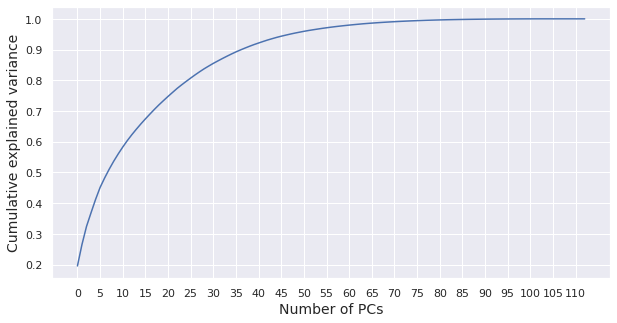

In [58]:
make_output_directory(output_dir/"pca/", force=True, nodelete=True)
cumExpVar = plot_explained_variance(
    pd_pca,
    num_of_components,
    file_path=output_dir/"pca/pd_pca_IE_explained_variance.png",
)

In [59]:
print(f"{pd_pca.explained_variance_ratio_.sum() * 100}% of the variance in the data set was catpured by the PCA")

99.99999999999997% of the variance in the data set was catpured by the PCA


**Variance captured per PC:**

Explore the variance in the data that is captured by each PC.

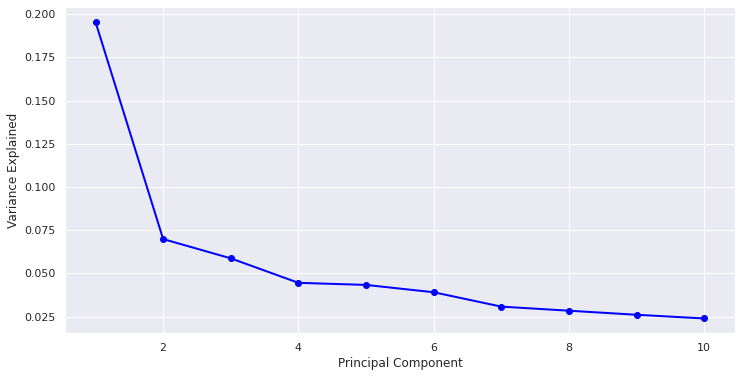

Explained variance for 1PC: 0.1954684055436529
Explained variance for 2PC: 0.06985348088097756
Explained variance for 3PC: 0.0587073352223538
Explained variance for 4PC: 0.04454188969815129
Explained variance for 5PC: 0.04332502617321747
Explained variance for 6PC: 0.03908642951253808
Explained variance for 7PC: 0.0307770888460498
Explained variance for 8PC: 0.028408524009888508
Explained variance for 9PC: 0.026056155921747582
Explained variance for 10PC: 0.023914712275103174


In [60]:
plot_scree(pd_pca, nComp=10, file_path=output_dir/"pca/pd_pca_IE_scree.png")

PC1 captures a signficantly greater amount degree of the varaince in the data set than all other PCs.  
PCs 2-4 capture comparable degrees of the variance

### Scatter and loadings plots

To explore the variance captured by each PC, plot different combinations of PCs onto a scatter plot where each axis represents a different PC and each point on the plot is a genome in the data set, using the `plot_pca()` function.

`plot_pca()` takes 6 positional argumets:
1. PCA object from `peform_pca()`
2. Scaling object (X_scaled) from `perform_pca()`
3. The dataframe of CAZy family frequencies, if you want to colour code the genomes by a specific grouping (i.e. by Genus), an additional column containing the grouping information needs to be added to the dataframe (e.g. listing the genus per genome)
4. The number of the first PC to be plotted, e.g. 1 for PC1 - int
5. The number of the second PC to be plotted, e.g. 2 for PC2 - int
6. The method to colour code the genomes by (e.g. 'Genus') - needs to match the name of the column containing the data in the dataframe of CAZy family frequencies

Owing to the majoirty of the variance captured by the PCA being captured by PCs 1-4, all possible combinations of these PCs were explored.

### PC1 vs PC2

Not applying hue order
Not Applying style


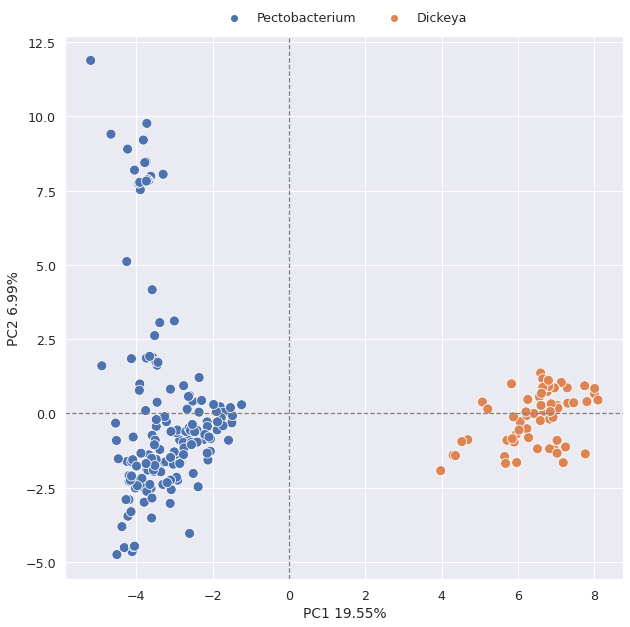

In [61]:
fam_freq_df_ggs['Genus'] = list(fam_freq_df['Genus'])  # add column to use for colour scheme

pc1_pc2_scatter_plt = plot_pca(
    pd_pca,
    X_scaled,
    fam_freq_df_ggs,
    1,
    2,
    'Genus',
    figsize=(10,10),
    file_path=output_dir/'pca/pd_IE_pc1_pc2.png',
)

**Loadings plot:**

A loadings plot shows the degree of correlation between each variable (i.e. CAZy family) and each of the PCs.

In [69]:
def plot_ie_loadings(
    pca,
    fam_df,
    first_pc,
    second_pc,
    threshold=0.7,
    font_scale=1.15,
    font_size=12,
    dpi=300,
    fig_size=(16,16),
    file_path=None,
    marker_size=100,
):
    """Build loadings plot
    
    Modified from cazomevolve - styles points using intracellular/extracellular classification
    
    :param pca: sklearn pca object
    :param fam_df: cazy family frequncy df
    :param first_pc: int, number of the first PC, e.g. PC1 == 1
    :param second_pc: int, number of the second PC e.g. PC2 == 2
    :param threshold: correlation cut off for showing labels
        Only families with a value greater than the threshold
        will be annotated
    :param font_scale: scale font
    :param font_size: font size of family labels
    :param fig_size: tuple (width, height) of final plot
    :param file_path: str, path to write out a figure.
        If None, no figure is saved
    
    Return nothing"""
    sns.set(font_scale=font_scale)

    # calculate loading = variables x loadings, returns an array
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    # get labels of variables, i.e. cazy families
    loadings_labels = list(fam_df.columns)
    try:
        loadings_labels.remove('Species')
    except (KeyError, ValueError):
        pass
    try:
        loadings_labels.remove('Genus')
    except (KeyError, ValueError):
        pass

    loadings_x = loadings[:,(first_pc-1)]
    loadings_y = loadings[:,(second_pc-1)]

    loadings_df = pd.DataFrame()
    loadings_df['loadings_x'] = loadings_x
    loadings_df['loadings_y'] = loadings_y

    cazy_class = []
    for lbl in loadings_labels:
        if lbl.find('GH') != -1:
            cazy_class.append('GH')
        elif lbl.find('GT') != -1:
            cazy_class.append('GT')
        elif lbl.find('PL') != -1:
            cazy_class.append('PL')
        elif lbl.find('CE') != -1:
            cazy_class.append('CE')
        elif lbl.find('AA') != -1:
            cazy_class.append('AA')
        else:
            cazy_class.append('CBM')

    loadings_df['cazy_class'] = cazy_class
    
    ie_classifications = []
    for lbl in loadings_labels:
        if lbl.startswith("i_"):
            ie_classifications.append('Intracellular')
        else:
            ie_classifications.append('Extracellular')
    loadings_df['ie_classification'] = ie_classifications

    plt.figure(figsize=fig_size)
    g = sns.scatterplot(
        x=loadings_x,
        y=loadings_y,
        data=loadings_df,
        hue=cazy_class,
        s=marker_size,
        style=ie_classifications,
    );
    
    g.axhline(0, linestyle='--', color='grey', linewidth=1.25);
    g.axvline(0, linestyle='--', color='grey', linewidth=1.25);
    g.set(xlim=(-1,1),ylim=(-1,1));
    plt.ylabel(f"PC{second_pc}") 
    plt.xlabel(f"PC{first_pc}")

    texts = [
        plt.text(
            xval,
            yval,
            lbl,
            ha='center',
            va='center',
            fontsize=font_size,
        ) for (xval, yval, lbl) in zip(
            loadings_x, loadings_y, loadings_labels
        ) if abs(xval) > threshold or abs(yval) > threshold
    ]
    adjustText.adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'));

    sns.move_legend(g, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False);
    
    if file_path is not None:
        plt.savefig(file_path, dpi=dpi, bbox_inches='tight')

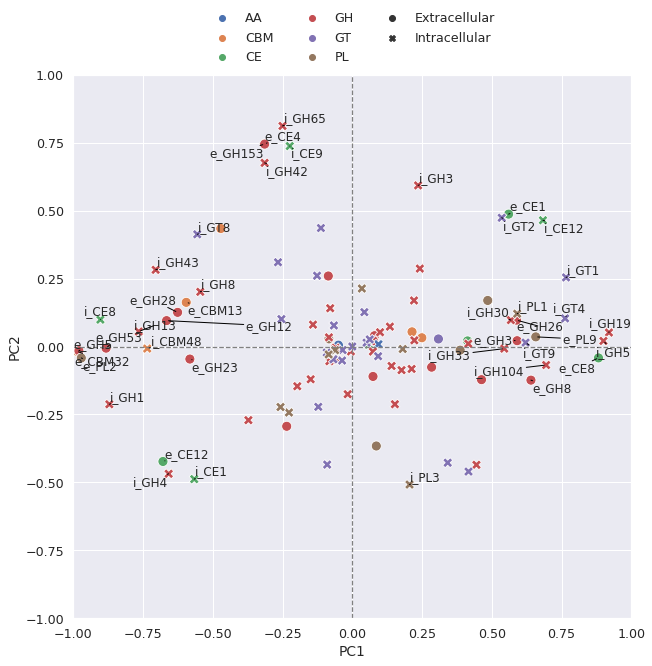

In [70]:
plot_ie_loadings(
    pd_pca,
    fam_freq_df_ggs,
    1,
    2,
    threshold=0.5,
    fig_size=(10,10),
    file_path=None,
    marker_size=100,
)

### PC1 vs PC3

In [ ]:
pc1_pc3_scatter_plt = plot_pca(
    pd_pca,
    X_scaled,
    fam_freq_df_ggs,
    1,
    3,
    'Genus',
    figsize=(5,5),
    marker_size=50,
)

### PC1 vs PC4

In [ ]:
pc1_pc4_scatter_plt = plot_pca(
    pd_pca,
    X_scaled,
    fam_freq_df_ggs,
    1,
    4,
    'Genus',
    figsize=(5,5),
    marker_size=50,
)

### PC2, PC3 and PC4

In [ ]:
pc2_pc3_scatter_plt = plot_pca(
    pd_pca,
    X_scaled,
    fam_freq_df_ggs,
    2,
    3,
    'Genus',
    figsize=(5,5),
    marker_size=50,
)

In [ ]:
pc2_pc4_scatter_plt = plot_pca(
    pd_pca,
    X_scaled,
    fam_freq_df_ggs,
    2,
    4,
    'Genus',
    figsize=(5,5),
    marker_size=50,
)

In [ ]:
pc3_pc4_scatter_plt = plot_pca(
    pd_pca,
    X_scaled,
    fam_freq_df_ggs,
    3,
    4,
    'Genus',
    figsize=(5,5),
    marker_size=50,
)

PC1 separates out the genomes in a manner that correlates with their genus classification: _Pectobacterium_ genomes are locataed in the negative PC1 axis, and _Dickeya_ genomes are located in the positive PC1 axis.

PCs 2-4 do not correlate with the genus classification.

### Species classification

To explore if PCs 2-4 correlated with the species classification for each genus, the _Pectobacterium_ and _Dickeya_ genomes were each subsetted, and the genomes projected onto all combinations of PCs 1-4, colour coding the genomes by the species classification.

In [ ]:
# subset the data
# and plot species classifications
fam_freq_df_ggs['Species'] = list(fam_freq_df['Species'])  # add column to use for colour scheme
pc1_pc2_scatter_plt = plot_pca(
    pd_pca,
    X_scaled,
    fam_freq_df_ggs,
    1,
    2,
    'Species',
    figsize=(10,10),
    style='Genus',
)

Split up the data onto separate plots, one plot per genus.

In [ ]:
fam_freq_df_ggs['Species'] = list(fam_freq_df['Species'])  # add column to use for colour scheme
sp_col = []
for i in range(len(fam_freq_df_ggs)):
    if fam_freq_df_ggs.iloc[i]['Genus'] == 'Dickeya':
        sp_col.append(None)
    else:
        sp_col.append(fam_freq_df_ggs.iloc[i]['Species'])
fam_freq_df_ggs['Species'] = sp_col
pc1_pc2_scatter_plt = plot_pca(
    pd_pca,
    X_scaled,
    fam_freq_df_ggs,
    1,
    2,
    'Species',
    figsize=(5,10),
    style='Species',
)

In [ ]:
fam_freq_df_ggs['Species'] = list(fam_freq_df['Species'])  # add column to use for colour scheme
sp_col = []
for i in range(len(fam_freq_df_ggs)):
    if fam_freq_df_ggs.iloc[i]['Genus'] == 'Pectobacterium':
        sp_col.append(None)
    else:
        sp_col.append(fam_freq_df_ggs.iloc[i]['Species'])
fam_freq_df_ggs['Species'] = sp_col
pc1_pc2_scatter_plt = plot_pca(
    pd_pca,
    X_scaled,
    fam_freq_df_ggs,
    1,
    2,
    'Species',
    figsize=(10,10),
    style='Species',
)

In [ ]:
fam_freq_df_ggs['Species'] = list(fam_freq_df['Species'])  # add column to use for colour scheme
pc1_pc2_scatter_plt = plot_pca(
    pd_pca,
    X_scaled,
    fam_freq_df_ggs,
    3,
    4,
    'Species',
    figsize=(10,10),
    style='Genus',
)

In [ ]:
pd_pca

## 7. Genus specific PCA

Rerun the PCA but for only genomes from each of the genera.

In [ ]:
# add column to separate genomes into respective genera
fam_freq_df_ggs['Genus'] = list(fam_freq_df_pd['Genus'])

# create one df for each genus
fam_freq_df_pecto = fam_freq_df_ggs[fam_freq_df_ggs['Genus'] == 'Pectobacterium']
fam_freq_df_dic = fam_freq_df_ggs[fam_freq_df_ggs['Genus'] == 'Dickeya']

# drop the Genus column so columns only contain numerical data
fam_freq_df_pecto = fam_freq_df_pecto.drop('Genus', axis=1)
fam_freq_df_dic = fam_freq_df_dic.drop('Genus', axis=1)

### _Pectobacterium_

In [ ]:
# exclude species column from pca
pecto_num_of_components = len(fam_freq_df_pecto.columns[:-1])
pecto_pca, pecto_X_scaled = perform_pca(
    fam_freq_df_pecto[fam_freq_df_pecto.columns[:-1]],
    pecto_num_of_components,
)
pecto_pca

In [ ]:
make_output_directory(Path("../results/pecto_dic/pca/pecto/"), force=True, nodelete=True)
cumExpVar = plot_explained_variance(
    pecto_pca,
    pecto_num_of_components,
    file_path="../results/pecto_dic/pca/pecto/pecto_explained_variance.png",
)

In [ ]:
print(f"{pecto_pca.explained_variance_ratio_.sum() * 100}% of the variance in the data set was catpured by the PCA")

In [ ]:
plot_scree(pecto_pca, nComp=10, file_path="../results/pecto_dic/pca/pecto/pecto_scree_plot.png")

In [ ]:
fam_freq_df_ggs['Species'] = list(fam_freq_df_pd['Species'])  # add column to use for colour scheme
temp_df = fam_freq_df_ggs[fam_freq_df_ggs['Genus'] == 'Pectobacterium']
fam_freq_df_pecto['Species'] = list(temp_df['Species'])

pc1_pc2_scatter_plt = plot_pca(
    pecto_pca,
    pecto_X_scaled,
    fam_freq_df_pecto,
    1,
    2,
    'Species',
    style='Species',
    figsize=(10,10),
    file_path="../results/pecto_dic/pca/pecto/pecto_pc1_pc2.png",
)

In [ ]:
pc1_pc3_scatter_plt = plot_pca(
    pecto_pca,
    pecto_X_scaled,
    fam_freq_df_pecto,
    1,
    3,
    'Species',
    style='Species',
    figsize=(10,12),
    file_path="../results/pecto_dic/pca/pecto/pecto_pc1_pc3.png",
)

In [ ]:
pc1_pc4_scatter_plt = plot_pca(
    pecto_pca,
    pecto_X_scaled,
    fam_freq_df_pecto,
    1,
    4,
    'Species',
    style='Species',
    figsize=(10,12),
    file_path="../results/pecto_dic/pca/pecto/pecto_pc1_pc4.png",
)

In [ ]:
pc2_pc3_scatter_plt = plot_pca(
    pecto_pca,
    pecto_X_scaled,
    fam_freq_df_pecto,
    2,
    3,
    'Species',
    style='Species',
    figsize=(10,12),
    file_path="../results/pecto_dic/pca/pecto/pecto_pc2_pc3.png",
)

In [ ]:
pc2_pc4_scatter_plt = plot_pca(
    pecto_pca,
    pecto_X_scaled,
    fam_freq_df_pecto,
    2,
    4,
    'Species',
    style='Species',
    figsize=(10,12),
    file_path="../results/pecto_dic/pca/pecto/pecto_pc2_pc4.png",
)

In [ ]:
pc3_pc4_scatter_plt = plot_pca(
    pecto_pca,
    pecto_X_scaled,
    fam_freq_df_pecto,
    3,
    4,
    'Species',
    style='Species',
    figsize=(10,10),
    file_path="../results/pecto_dic/pca/pecto/pecto_pc3_pc4.png",
)

The _P.carotovorum_ species repeated splits into two groups or clusters on the above PCA plots.

Annotate the genomes and look at the phylogenetic tree.

In [ ]:
X_pca = pecto_pca.transform(pecto_X_scaled)

plt.figure(figsize=(10,10))
sns.set(font_scale=1.15)

g = sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    data=fam_freq_df_pecto,
    hue='Species',
    style='Species',
    s=100,
    markers=True,
)

g.axhline(0, linestyle='--', color='grey', linewidth=1.25);
g.axvline(0, linestyle='--', color='grey', linewidth=1.25);

plt.ylabel(f"PC2 {100 * pecto_pca.explained_variance_ratio_[1]:.2f}%");
plt.xlabel(f"PC1 {100 * pecto_pca.explained_variance_ratio_[0]:.2f}%");
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

genome_lbls = ["-".join(_) for _ in fam_freq_df_pecto.index]
x_vals = X_pca[:,0]
y_vals = X_pca[:,1]

texts = [
    plt.text(
        xval,
        yval,
        lbl,
        ha='center',
        va='center',
        fontsize=12,
    ) for (xval, yval, lbl) in zip(
        x_vals, y_vals, genome_lbls
    ) if ((yval > 2) and (xval < 0))
]
adjustText.adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'));

plt.savefig('../results/pecto_dic/pca/pecto/pecto_pc1_pc2_LABELLED.png', bbox_inches='tight', format='png')

In [ ]:
[_ for _ in texts]

In [ ]:
import re
small_pc_group = [re.match(r"GCF_\d+.\d+-", _.properties()['text']).group()[:-1] for _ in texts]
with open("../data/genomic_accessions/small_p-carotovorum_grp", "w") as fh:
    for genome in small_pc_group:
        fh.write(f"{genome}\n")

In [ ]:
a = ""
for g in small_pc_group:
    a += f" {g}"
a

In [ ]:
large_pc_group = []
for i in range(len(fam_freq_df_pecto)):
    sp = fam_freq_df_pecto.iloc[i].name[-1]
    if sp.startswith("carotovorum"):
        gnm = fam_freq_df_pecto.iloc[i].name[0]
        if gnm not in small_pc_group:
            large_pc_group.append(gnm)
with open("../data/genomic_accessions/large_p-carotovorum_grp", "w") as fh:
    for genome in large_pc_group:
        fh.write(f"{genome}\n")

In [ ]:
pc_group = []
for i in range(len(fam_freq_df_pecto)):
    genus = fam_freq_df_pecto.iloc[i].name[1]
    if genus == 'Pectobacterium':
        pc_group.append(gnm)
len(pc_group)

In [ ]:
X_pca = pecto_pca.transform(pecto_X_scaled)

plt.figure(figsize=(10,10))
sns.set(font_scale=1.15)

g = sns.scatterplot(
    x=X_pca[:,2],
    y=X_pca[:,3],
    data=fam_freq_df_pecto,
    hue='Species',
    style='Species',
    s=100,
    markers=True,
)

g.axhline(0, linestyle='--', color='grey', linewidth=1.25);
g.axvline(0, linestyle='--', color='grey', linewidth=1.25);

plt.xlabel(f"PC3 {100 * pecto_pca.explained_variance_ratio_[2]:.2f}%");
plt.ylabel(f"PC4 {100 * pecto_pca.explained_variance_ratio_[3]:.2f}%");
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

genome_lbls = ["-".join(_) for _ in fam_freq_df_pecto.index]
x_vals = X_pca[:,2]
y_vals = X_pca[:,3]

texts = [
    plt.text(
        xval,
        yval,
        lbl,
        ha='center',
        va='center',
        fontsize=12,
    ) for (xval, yval, lbl) in zip(
        x_vals, y_vals, genome_lbls
    ) if ((yval < -2.5) and (xval > 2.5))
]
adjustText.adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'));

plt.savefig('../results/pecto_dic/pca/pecto/pecto_pc3_pc4_LABELLED.png', bbox_inches='tight', format='png')

### Dickeya

In [ ]:
dic_num_of_components = len(fam_freq_df_dic.columns[:-1])
dic_pca, dic_X_scaled = perform_pca(
    fam_freq_df_dic[fam_freq_df_dic.columns[:-1]],
    dic_num_of_components,
)
dic_pca

In [ ]:
make_output_directory(Path("../results/pecto_dic/pca/dickeya/"), force=True, nodelete=True)

cumExpVar = plot_explained_variance(
    dic_pca,
    dic_num_of_components,
    file_path="../results/pecto_dic/pca/dickeya/dic_explained_variance.png",
)

In [ ]:
print(f"{dic_pca.explained_variance_ratio_.sum() * 100}% of the variance in the data set was catpured by the PCA")

In [ ]:
plot_scree(dic_pca, nComp=10, file_path="../results/pecto_dic/pca/dickeya/dic_scree_plot.png")

In [ ]:
fam_freq_df_ggs['Species'] = list(fam_freq_df_pd['Species'])  # add column to use for colour scheme
temp_df = fam_freq_df_ggs[fam_freq_df_ggs['Genus'] == 'Dickeya']
fam_freq_df_dic['Species'] = list(temp_df['Species'])

pc1_pc2_scatter_plt = plot_pca(
    dic_pca,
    dic_X_scaled,
    fam_freq_df_dic,
    1,
    2,
    'Species',
    style='Species',
    figsize=(10,10),
    file_path="../results/pecto_dic/pca/dickeya/dic_pc1_pc2.png",
)

In [ ]:
pc1_pc3_scatter_plt = plot_pca(
    dic_pca,
    dic_X_scaled,
    fam_freq_df_dic,
    1,
    3,
    'Species',
    style='Species',
    figsize=(10,10),
    file_path="../results/pecto_dic/pca/dickeya/dic_pc1_pc3.png",
)

In [ ]:
pc1_pc4_scatter_plt = plot_pca(
    dic_pca,
    dic_X_scaled,
    fam_freq_df_dic,
    1,
    4,
    'Species',
    style='Species',
    figsize=(10,10),
    file_path="../results/pecto_dic/pca/dickeya/dic_pc1_pc4.png",
)

In [ ]:
pc2_pc3_scatter_plt = plot_pca(
    dic_pca,
    dic_X_scaled,
    fam_freq_df_dic,
    2,
    3,
    'Species',
    style='Species',
    figsize=(10,10),
    file_path="../results/pecto_dic/pca/dickeya/dic_pc2_pc3.png",
)

In [ ]:
pc2_pc4_scatter_plt = plot_pca(
    dic_pca,
    dic_X_scaled,
    fam_freq_df_dic,
    2,
    4,
    'Species',
    style='Species',
    figsize=(10,12),
    file_path="../results/pecto_dic/pca/dickeya/dic_pc2_pc4.png",
)

In [ ]:
pc3_pc4_scatter_plt = plot_pca(
    dic_pca,
    dic_X_scaled,
    fam_freq_df_dic,
    3,
    4,
    'Species',
    style='Species',
    figsize=(10,12),
    file_path="../results/pecto_dic/pca/dickeya/dic_pc3_pc4.png",
)

PC4 separated out one _dadantii_ genome from all other _Dickeya_ genomes.

Regenerate the plot and label the genome.

In [ ]:
X_pca = dic_pca.transform(dic_X_scaled)

plt.figure(figsize=(10,12))
sns.set(font_scale=1.15)

g = sns.scatterplot(
    x=X_pca[:,2],
    y=X_pca[:,3],
    data=fam_freq_df_dic,
    hue='Species',
    style='Species',
    s=100,
    markers=True,
)

g.axhline(0, linestyle='--', color='grey', linewidth=1.25);
g.axvline(0, linestyle='--', color='grey', linewidth=1.25);

plt.ylabel(f"PC4 {100 * dic_pca.explained_variance_ratio_[2]:.2f}%");
plt.xlabel(f"PC3 {100 * dic_pca.explained_variance_ratio_[3]:.2f}%");
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

genome_lbls = ["-".join(_) for _ in fam_freq_df_dic.index]
x_vals = X_pca[:,2]
y_vals = X_pca[:,3]

texts = [
    plt.text(
        xval,
        yval,
        lbl,
        ha='center',
        va='center',
        fontsize=12,
    ) for (xval, yval, lbl) in zip(
        x_vals, y_vals, genome_lbls
    ) if (yval > 12)
]
adjustText.adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'));

plt.savefig('../results/pecto_dic/pca/dickeya/dic_pc3_pc4_LABELLED.png', bbox_inches='tight', format='png')

Looking at the phylogenetic tree (which was reconstructed from SCOs by RaxML-NG), the _D.dadantii_ genome that is placed in isolation, is clustered with the other genomes from its species in the tree. However, the GCA\_018904205.1 genome was on a separate branch from the other genomes, and on a branch that diverged earlier.